In [10]:
"""
Import dependancies
"""

#import Analysis.DataAnalysis as da
#import NLP.TextClassifier as tc
import pandas as pd
import csv
from pandas import datetime as dt

import mysql.connector
import time
import pre_config
import pymongo
import requests
import json

In [11]:


user ='Snowman'
topic ='pjp_index'
ml_url ='http://52.5.161.190:5001/ml_api/v1/get_classified_training_data/' + user + '/' + topic
config_path = '/Users/michaelsnow/PycharmProjects/S3_files/Social-configs.JSON'
training_data = requests.get(ml_url)

training_data_json = json.loads(training_data.text)

training_data_json

with open(config_path, "r") as file:
        app_config = json.load(file)

app_config["mysql_user"]

                

'root'

In [12]:
# Create MySQL connection


cnx = mysql.connector.connect(user=app_config["mysql_user"], password=app_config["mysql_password"],
                              host=app_config["mysql_host"],
                              database="Snowman")
mycursor = cnx.cursor()
                                              
# Test functions for connecting to mysql on AWS
#sql = "SELECT * FROM Snowman.pjp_index_training_data;"
#mycursor.execute(sql)
#my_results = mycursor.fetchall()
#my_results


#set tweet database
#pjp = da.tweetDB['pjp_index']

In [13]:
#remote connect to AWS MongoDB
mongo_user = app_config["aws_mongo_twitter_user"]
mongo_pwd = app_config["aws_mongo_twitter_pwd"]
url = '@3.222.222.72/Snowman'

aws_client = pymongo.MongoClient('mongodb://' +mongo_user + ':'+mongo_pwd+url)


aws_db = aws_client.Snowman

aws_pjp = aws_db['pjp_index']

agg = aws_pjp.aggregate([{"$sample":{"size":100}}])

aws_pjp.find_one()


{'_id': ObjectId('5dedbeef20c39cc2dde47970'),
 'created_at': 'Mon Dec 09 03:26:33 +0000 2019',
 'id': 1203878574975049728,
 'id_str': '1203878574975049728',
 'text': 'why’d i think this was abt butterfly from RBB album 😭',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 108697517,
  'id_str': '108697517',
  'name': '➖',
  'screen_name': 'dohyonsbf',
  'location': '윙스, 원잇, 블링크',
  'url': 'http://www.blackpink.com',
  'description': '#JIEUN: i’m in love with yuuri idc',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 277,
  'friends_count': 276,
  'listed_count': 3,
  'favourites_count': 7037,
  'statuses_count': 8757,
  'created_at': 'Tue Jan 26 19:44:30 +0000 2010',
  'utc_offset': None,
  'tim

In [14]:
"""
reformats tweet time to match stock price time
"""

def format_tweet_time(tweet_time):
    formated_time = dt.strptime(tweet_time, '%a %b %d %H:%M:%S +0000 %Y')
    formated_time -= pd.DateOffset(hours=4)
    return str(formated_time)

"""
Saves tweets to a CSV file
"""

def save_tweet_results(analysis, data):
    with open('pjp_relevant_tweets.csv', 'a') as csv_file:
        row = [analysis, data['id'], data['text'], data['user']['screen_name'], data['user']['followers_count'],format_tweet_time(data['created_at']),data['response']]
        writer = csv.writer(csv_file)
        writer.writerow(row)
        


In [15]:
 """
Itterates through all the tweets within a database and determines if the text is relevant.  If the text is 
relevant then the tweet is saved to a csv file.

⚠️ WARNING - This process does not check to see if you already classified a tweet and stored in the CSV file.
Because of this duplicates are inevitable. Not sure it is an issue at this time."""

classify_url = "http://52.5.161.190:5001/ml_api/v1/classify_data"

payload = {
  "user_id": "Snowman",
  "topic_name": "pjp_index",
  "record_id": "",
  "text": ""
}


for tweet in agg:
    
    payload['record_id'] = tweet['id']
    payload['text'] = tweet['text']
    response = requests.post(classify_url, json=payload)
    print(tweet['text'], response.json())


for tweet in agg:
    try:
        payload['record_id'] = tweet['id']
        payload['text'] = tweet['text']
        response = requests.post(classify_url, json=payload)
        tweet['response'] = response.json()
        save_tweet_results('pjp_index',tweet)
    except:
        print("There was an error")
        pass
    

RT @CHANEL730: I love  those friends that get angrier abt  situations you’re in than you do 1212507615621611520 is Relevant? FALSE
RT @brushykb: i love the internet but rly it gave so many ppl brainrot thinking they need to act like they know something about everything… 1214259658195701765 is Relevant? FALSE
RT @mintho1025: 🐱What are you gonna do after fansign?
:I’m into Tarot recently so I’ll go for tarot reading
🐱Taro? Really? I also really li… 1215656197329543173 is Relevant? FALSE
RT @tanmay_shinde99: When it's abt 
Participation of kids in #ClimateChange demonstrations or  #SaveAareyforest ,govt &amp;several other ppl te… 1216430166882144256 is Relevant? FALSE
RT @dreams_icey: I must say #ParasChhabra is d smartest person in d house he cut off frm sana at d right time! 
#SidharthShukla got trapped… 1216636337782018048 is Relevant? FALSE
@ImAchickenstan I dont like my lockscreen being anything bc I will get judged so it's a pic a took and it's been th… https://t.co/Oh64ukapFc 12103

RT @blaqbfly: that white actress’s comments abt bts didn’t even bother me bc john cena’s response was enough to make her feel humiliated as… 1217892008142036998 is Relevant? FALSE
RT @bonsaiboyjoon: Y’all really made her take down the tweet abt YSL contacting her bc of comments and DMs harassing her. Literally fuck ar… 1204062304364630017 is Relevant? FALSE
RT @smitadeshmukh: The most disturbing aspect of the #CAA protests for me, a former journalist, has been the media allowing the disinformat… 1219147303010701312 is Relevant? FALSE
will be deleted in abt an hour because i feel insecure woo 1215986552289091587 is Relevant? FALSE
RT @Neha45993729: Guyz think abt tht channel ki Kya mazburi hogi ki unko pindu ko bulana pada😂

As no sane person wud cme &amp; support bhalu👎👎… 1218553659904028674 is Relevant? FALSE
@ytjazminn what abt “that shits unattraCtive” 1215534295638368257 is Relevant? FALSE
RT @TomPodolec: EXTENDED VIDEO Air Canada Jazz #AC8684 to Saguenay lost a wheel as it departe

In [ ]:
"""
AWS version

Itterates through all the tweets within a database and determines if the text is relevant.  If the text is 
relevant then the tweet is saved to a csv file.

⚠️ WARNING - This process does not check to see if you already classified a tweet and stored in the CSV file.
Because of this duplicates are inevitable. Not sure it is an issue at this time.
"""

error_count=0

def notify_error():
    if error_count%10 != 0:
        pass
    else:
        print('Error '+str(error_count))

for tweet in aws_pjp.find():
    try:
        if tc.TextClassifier().is_relevant(tweet['text']) == 'Relevant':
            save_tweet_results('pjp_index',tweet)
    except:
        error_count +=1
        notify_error()
        #tweet
        pass


Error 10
Error 20
Error 30
Error 40
Error 50
Error 60
Error 70
Error 80
Error 90
Error 100
Error 110
Error 120
Error 130
Error 140
Error 150
Error 160
Error 170
Error 180
Error 190
Error 200
Error 210
Error 220
Error 230
Error 240
Error 250
Error 260
Error 270
Error 280
Error 290
Error 300
Error 310
Error 320
Error 330
Error 340
Error 350
Error 360
Error 370
Error 380
Error 390
Error 400
Error 410
Error 420
Error 430
Error 440
Error 450
Error 460
Error 470
Error 480
Error 490
Error 500
Error 510
Error 520
Error 530
Error 540
Error 550
Error 560
Error 570
Error 580
Error 590
Error 600
Error 610
Error 620
Error 630
Error 640
Error 650
Error 660
Error 670
Error 680
Error 690
Error 700
Error 710
Error 720
Error 730
Error 740
Error 750
Error 760
Error 770
Error 780
Error 790
Error 800
Error 810
Error 820
Error 830
Error 840
Error 850
Error 860
Error 870
Error 880
Error 890
Error 900
Error 910
Error 920
Error 930
Error 940
Error 950
Error 960
Error 970
Error 980
Error 990
Error 1000
Error 10

Error 9100
Error 9110
Error 9120
Error 9130
Error 9140
Error 9150
Error 9160
Error 9170
Error 9180
Error 9190
Error 9200
Error 9210
Error 9220
Error 9230
Error 9240
Error 9250
Error 9260
Error 9270
Error 9280
Error 9290
Error 9300
Error 9310
Error 9320
Error 9330
Error 9340
Error 9350
Error 9360
Error 9370
Error 9380
Error 9390
Error 9400
Error 9410
Error 9420
Error 9430
Error 9440
Error 9450
Error 9460
Error 9470
Error 9480
Error 9490
Error 9500
Error 9510
Error 9520
Error 9530
Error 9540
Error 9550
Error 9560
Error 9570
Error 9580
Error 9590
Error 9600
Error 9610
Error 9620
Error 9630
Error 9640
Error 9650
Error 9660
Error 9670
Error 9680
Error 9690
Error 9700
Error 9710
Error 9720
Error 9730
Error 9740
Error 9750
Error 9760
Error 9770
Error 9780
Error 9790
Error 9800
Error 9810
Error 9820
Error 9830
Error 9840
Error 9850
Error 9860
Error 9870
Error 9880
Error 9890
Error 9900
Error 9910
Error 9920
Error 9930
Error 9940
Error 9950
Error 9960
Error 9970
Error 9980
Error 9990
Error 1000

Error 18240
Error 18250
Error 18260
Error 18270
Error 18280
Error 18290
Error 18300
Error 18310
Error 18320
Error 18330
Error 18340
Error 18350
Error 18360
Error 18370
Error 18380
Error 18390
Error 18400
Error 18410
Error 18420
Error 18430
Error 18440
Error 18450
Error 18460
Error 18470
Error 18480
Error 18490
Error 18500
Error 18510
Error 18520
Error 18530
Error 18540
Error 18550
Error 18560
Error 18570
Error 18580
Error 18590
Error 18600
Error 18610
Error 18620
Error 18630
Error 18640
Error 18650
Error 18660
Error 18670
Error 18680
Error 18690
Error 18700
Error 18710
Error 18720
Error 18730
Error 18740
Error 18750
Error 18760
Error 18770
Error 18780
Error 18790
Error 18800
Error 18810
Error 18820
Error 18830
Error 18840
Error 18850
Error 18860
Error 18870
Error 18880
Error 18890
Error 18900
Error 18910
Error 18920
Error 18930
Error 18940
Error 18950
Error 18960
Error 18970
Error 18980
Error 18990
Error 19000
Error 19010
Error 19020
Error 19030
Error 19040
Error 19050
Error 19060
Erro

Error 27130
Error 27140
Error 27150
Error 27160
Error 27170
Error 27180
Error 27190
Error 27200
Error 27210
Error 27220
Error 27230
Error 27240
Error 27250
Error 27260
Error 27270
Error 27280
Error 27290
Error 27300
Error 27310
Error 27320
Error 27330
Error 27340
Error 27350
Error 27360
Error 27370
Error 27380
Error 27390
Error 27400
Error 27410
Error 27420
Error 27430
Error 27440
Error 27450
Error 27460
Error 27470
Error 27480
Error 27490
Error 27500
Error 27510
Error 27520
Error 27530
Error 27540
Error 27550
Error 27560
Error 27570
Error 27580
Error 27590
Error 27600
Error 27610
Error 27620
Error 27630
Error 27640
Error 27650
Error 27660
Error 27670
Error 27680
Error 27690
Error 27700
Error 27710
Error 27720
Error 27730
Error 27740
Error 27750
Error 27760
Error 27770
Error 27780
Error 27790
Error 27800
Error 27810
Error 27820
Error 27830
Error 27840
Error 27850
Error 27860
Error 27870
Error 27880
Error 27890
Error 27900
Error 27910
Error 27920
Error 27930
Error 27940
Error 27950
Erro

Error 35810
Error 35820
Error 35830
Error 35840
Error 35850
Error 35860
Error 35870
Error 35880
Error 35890
Error 35900
Error 35910
Error 35920
Error 35930
Error 35940
Error 35950
Error 35960
Error 35970
Error 35980
Error 35990
Error 36000
Error 36010
Error 36020
Error 36030
Error 36040
Error 36050
Error 36060
Error 36070
Error 36080
Error 36090
Error 36100
Error 36110
Error 36120
Error 36130
Error 36140
Error 36150
Error 36160
Error 36170
Error 36180
Error 36190
Error 36200
Error 36210
Error 36220
Error 36230
Error 36240
Error 36250
Error 36260
Error 36270
Error 36280
Error 36290
Error 36300
Error 36310
Error 36320
Error 36330
Error 36340
Error 36350
Error 36360
Error 36370
Error 36380
Error 36390
Error 36400
Error 36410
Error 36420
Error 36430
Error 36440
Error 36450
Error 36460
Error 36470
Error 36480
Error 36490
Error 36500
Error 36510
Error 36520
Error 36530
Error 36540
Error 36550
Error 36560
Error 36570
Error 36580
Error 36590
Error 36600
Error 36610
Error 36620
Error 36630
Erro

Error 44310
Error 44320
Error 44330
Error 44340
Error 44350
Error 44360
Error 44370
Error 44380
Error 44390
Error 44400
Error 44410
Error 44420
Error 44430
Error 44440
Error 44450
Error 44460
Error 44470
Error 44480
Error 44490
Error 44500
Error 44510
Error 44520
Error 44530
Error 44540
Error 44550
Error 44560
Error 44570
Error 44580
Error 44590
Error 44600
Error 44610
Error 44620
Error 44630
Error 44640
Error 44650
Error 44660
Error 44670
Error 44680
Error 44690
Error 44700
Error 44710
Error 44720
Error 44730
Error 44740
Error 44750
Error 44760
Error 44770
Error 44780
Error 44790
Error 44800
Error 44810
Error 44820
Error 44830
Error 44840
Error 44850
Error 44860
Error 44870
Error 44880
Error 44890
Error 44900
Error 44910
Error 44920
Error 44930
Error 44940
Error 44950
Error 44960
Error 44970
Error 44980
Error 44990
Error 45000
Error 45010
Error 45020
Error 45030
Error 45040
Error 45050
Error 45060
Error 45070
Error 45080
Error 45090
Error 45100
Error 45110
Error 45120
Error 45130
Erro

Error 52840
Error 52850
Error 52860
Error 52870
Error 52880
Error 52890
Error 52900
Error 52910
Error 52920
Error 52930
Error 52940
Error 52950
Error 52960
Error 52970
Error 52980
Error 52990
Error 53000
Error 53010
Error 53020
Error 53030
Error 53040
Error 53050
Error 53060
Error 53070
Error 53080
Error 53090
Error 53100
Error 53110
Error 53120
Error 53130
Error 53140
Error 53150
Error 53160
Error 53170
Error 53180
Error 53190
Error 53200
Error 53210
Error 53220
Error 53230
Error 53240
Error 53250
Error 53260
Error 53270
Error 53280
Error 53290
Error 53300
Error 53310
Error 53320
Error 53330
Error 53340
Error 53350
Error 53360
Error 53370
Error 53380
Error 53390
Error 53400
Error 53410
Error 53420
Error 53430
Error 53440
Error 53450
Error 53460
Error 53470
Error 53480
Error 53490
Error 53500
Error 53510
Error 53520
Error 53530
Error 53540
Error 53550
Error 53560
Error 53570
Error 53580
Error 53590
Error 53600
Error 53610
Error 53620
Error 53630
Error 53640
Error 53650
Error 53660
Erro

Error 61310
Error 61320
Error 61330
Error 61340
Error 61350
Error 61360
Error 61370
Error 61380
Error 61390
Error 61400
Error 61410
Error 61420
Error 61430
Error 61440
Error 61450
Error 61460
Error 61470
Error 61480
Error 61490
Error 61500
Error 61510
Error 61520
Error 61530
Error 61540
Error 61550
Error 61560
Error 61570
Error 61580
Error 61590
Error 61600
Error 61610
Error 61620
Error 61630
Error 61640
Error 61650
Error 61660
Error 61670
Error 61680
Error 61690
Error 61700
Error 61710
Error 61720
Error 61730
Error 61740
Error 61750
Error 61760
Error 61770
Error 61780
Error 61790
Error 61800
Error 61810
Error 61820
Error 61830
Error 61840
Error 61850
Error 61860
Error 61870
Error 61880
Error 61890
Error 61900
Error 61910
Error 61920
Error 61930
Error 61940
Error 61950
Error 61960
Error 61970
Error 61980
Error 61990
Error 62000
Error 62010
Error 62020
Error 62030
Error 62040
Error 62050
Error 62060
Error 62070
Error 62080
Error 62090
Error 62100
Error 62110
Error 62120
Error 62130
Erro

Error 70170
Error 70180
Error 70190
Error 70200
Error 70210
Error 70220
Error 70230
Error 70240
Error 70250
Error 70260
Error 70270
Error 70280
Error 70290
Error 70300
Error 70310
Error 70320
Error 70330
Error 70340
Error 70350
Error 70360
Error 70370
Error 70380
Error 70390
Error 70400
Error 70410
Error 70420
Error 70430
Error 70440
Error 70450
Error 70460
Error 70470
Error 70480
Error 70490
Error 70500
Error 70510
Error 70520
Error 70530
Error 70540
Error 70550
Error 70560
Error 70570
Error 70580
Error 70590
Error 70600
Error 70610
Error 70620
Error 70630
Error 70640
Error 70650
Error 70660
Error 70670
Error 70680
Error 70690
Error 70700
Error 70710
Error 70720
Error 70730
Error 70740
Error 70750
Error 70760
Error 70770
Error 70780
Error 70790
Error 70800
Error 70810
Error 70820
Error 70830
Error 70840
Error 70850
Error 70860
Error 70870
Error 70880
Error 70890
Error 70900
Error 70910
Error 70920
Error 70930
Error 70940
Error 70950
Error 70960
Error 70970
Error 70980
Error 70990
Erro

Error 79600
Error 79610
Error 79620
Error 79630
Error 79640
Error 79650
Error 79660
Error 79670
Error 79680
Error 79690
Error 79700
Error 79710
Error 79720
Error 79730
Error 79740
Error 79750
Error 79760
Error 79770
Error 79780
Error 79790
Error 79800
Error 79810
Error 79820
Error 79830
Error 79840
Error 79850
Error 79860
Error 79870
Error 79880
Error 79890
Error 79900
Error 79910
Error 79920
Error 79930
Error 79940
Error 79950
Error 79960
Error 79970
Error 79980
Error 79990
Error 80000
Error 80010
Error 80020
Error 80030
Error 80040
Error 80050
Error 80060
Error 80070
Error 80080
Error 80090
Error 80100
Error 80110
Error 80120
Error 80130
Error 80140
Error 80150
Error 80160
Error 80170
Error 80180
Error 80190
Error 80200
Error 80210
Error 80220
Error 80230
Error 80240
Error 80250
Error 80260
Error 80270
Error 80280
Error 80290
Error 80300
Error 80310
Error 80320
Error 80330
Error 80340
Error 80350
Error 80360
Error 80370
Error 80380
Error 80390
Error 80400
Error 80410
Error 80420
Erro

Error 88090
Error 88100
Error 88110
Error 88120
Error 88130
Error 88140
Error 88150
Error 88160
Error 88170
Error 88180
Error 88190
Error 88200
Error 88210
Error 88220
Error 88230
Error 88240
Error 88250
Error 88260
Error 88270
Error 88280
Error 88290
Error 88300
Error 88310
Error 88320
Error 88330
Error 88340
Error 88350
Error 88360
Error 88370
Error 88380
Error 88390
Error 88400
Error 88410
Error 88420
Error 88430
Error 88440
Error 88450
Error 88460
Error 88470
Error 88480
Error 88490
Error 88500
Error 88510
Error 88520
Error 88530
Error 88540
Error 88550
Error 88560
Error 88570
Error 88580
Error 88590
Error 88600
Error 88610
Error 88620
Error 88630
Error 88640
Error 88650
Error 88660
Error 88670
Error 88680
Error 88690
Error 88700
Error 88710
Error 88720
Error 88730
Error 88740
Error 88750
Error 88760
Error 88770
Error 88780
Error 88790
Error 88800
Error 88810
Error 88820
Error 88830
Error 88840
Error 88850
Error 88860
Error 88870
Error 88880
Error 88890
Error 88900
Error 88910
Erro

Error 96310
Error 96320
Error 96330
Error 96340
Error 96350
Error 96360
Error 96370
Error 96380
Error 96390
Error 96400
Error 96410
Error 96420
Error 96430
Error 96440
Error 96450
Error 96460
Error 96470
Error 96480
Error 96490
Error 96500
Error 96510
Error 96520
Error 96530
Error 96540
Error 96550
Error 96560
Error 96570
Error 96580
Error 96590
Error 96600
Error 96610
Error 96620
Error 96630
Error 96640
Error 96650
Error 96660
Error 96670
Error 96680
Error 96690
Error 96700
Error 96710
Error 96720
Error 96730
Error 96740
Error 96750
Error 96760
Error 96770
Error 96780
Error 96790
Error 96800
Error 96810
Error 96820
Error 96830
Error 96840
Error 96850
Error 96860
Error 96870
Error 96880
Error 96890
Error 96900
Error 96910
Error 96920
Error 96930
Error 96940
Error 96950
Error 96960
Error 96970
Error 96980
Error 96990
Error 97000
Error 97010
Error 97020
Error 97030
Error 97040
Error 97050
Error 97060
Error 97070
Error 97080
Error 97090
Error 97100
Error 97110
Error 97120
Error 97130
Erro

Error 104890
Error 104900
Error 104910
Error 104920
Error 104930
Error 104940
Error 104950
Error 104960
Error 104970
Error 104980
Error 104990
Error 105000
Error 105010
Error 105020
Error 105030
Error 105040
Error 105050
Error 105060
Error 105070
Error 105080
Error 105090
Error 105100
Error 105110
Error 105120
Error 105130
Error 105140
Error 105150
Error 105160
Error 105170
Error 105180
Error 105190
Error 105200
Error 105210
Error 105220
Error 105230
Error 105240
Error 105250
Error 105260
Error 105270
Error 105280
Error 105290
Error 105300
Error 105310
Error 105320
Error 105330
Error 105340
Error 105350
Error 105360
Error 105370
Error 105380
Error 105390
Error 105400
Error 105410
Error 105420
Error 105430
Error 105440
Error 105450
Error 105460
Error 105470
Error 105480
Error 105490
Error 105500
Error 105510
Error 105520
Error 105530
Error 105540
Error 105550
Error 105560
Error 105570
Error 105580
Error 105590
Error 105600
Error 105610
Error 105620
Error 105630
Error 105640
Error 105650

Error 113330
Error 113340
Error 113350
Error 113360
Error 113370
Error 113380
Error 113390
Error 113400
Error 113410
Error 113420
Error 113430
Error 113440
Error 113450
Error 113460
Error 113470
Error 113480
Error 113490
Error 113500
Error 113510
Error 113520
Error 113530
Error 113540
Error 113550
Error 113560
Error 113570
Error 113580
Error 113590
Error 113600
Error 113610
Error 113620
Error 113630
Error 113640
Error 113650
Error 113660
Error 113670
Error 113680
Error 113690
Error 113700
Error 113710
Error 113720
Error 113730
Error 113740
Error 113750
Error 113760
Error 113770
Error 113780
Error 113790
Error 113800
Error 113810
Error 113820
Error 113830
Error 113840
Error 113850
Error 113860
Error 113870
Error 113880
Error 113890
Error 113900
Error 113910
Error 113920
Error 113930
Error 113940
Error 113950
Error 113960
Error 113970
Error 113980
Error 113990
Error 114000
Error 114010
Error 114020
Error 114030
Error 114040
Error 114050
Error 114060
Error 114070
Error 114080
Error 114090

Error 122260
Error 122270
Error 122280
Error 122290
Error 122300
Error 122310
Error 122320
Error 122330
Error 122340
Error 122350
Error 122360
Error 122370
Error 122380
Error 122390
Error 122400
Error 122410
Error 122420
Error 122430
Error 122440
Error 122450
Error 122460
Error 122470
Error 122480
Error 122490
Error 122500
Error 122510
Error 122520
Error 122530
Error 122540
Error 122550
Error 122560
Error 122570
Error 122580
Error 122590
Error 122600
Error 122610
Error 122620
Error 122630
Error 122640
Error 122650
Error 122660
Error 122670
Error 122680
Error 122690
Error 122700
Error 122710
Error 122720
Error 122730
Error 122740
Error 122750
Error 122760
Error 122770
Error 122780
Error 122790
Error 122800
Error 122810
Error 122820
Error 122830
Error 122840
Error 122850
Error 122860
Error 122870
Error 122880
Error 122890
Error 122900
Error 122910
Error 122920
Error 122930
Error 122940
Error 122950
Error 122960
Error 122970
Error 122980
Error 122990
Error 123000
Error 123010
Error 123020

Error 131360
Error 131370
Error 131380
Error 131390
Error 131400
Error 131410
Error 131420
Error 131430
Error 131440
Error 131450
Error 131460
Error 131470
Error 131480
Error 131490
Error 131500
Error 131510
Error 131520
Error 131530
Error 131540
Error 131550
Error 131560
Error 131570
Error 131580
Error 131590
Error 131600
Error 131610
Error 131620
Error 131630
Error 131640
Error 131650
Error 131660
Error 131670
Error 131680
Error 131690
Error 131700
Error 131710
Error 131720
Error 131730
Error 131740
Error 131750
Error 131760
Error 131770
Error 131780
Error 131790
Error 131800
Error 131810
Error 131820
Error 131830
Error 131840
Error 131850
Error 131860
Error 131870
Error 131880
Error 131890
Error 131900
Error 131910
Error 131920
Error 131930
Error 131940
Error 131950
Error 131960
Error 131970
Error 131980
Error 131990
Error 132000
Error 132010
Error 132020
Error 132030
Error 132040
Error 132050
Error 132060
Error 132070
Error 132080
Error 132090
Error 132100
Error 132110
Error 132120

Error 137790
Error 137800
Error 137810
Error 137820
Error 137830
Error 137840
Error 137850
Error 137860
Error 137870
Error 137880
Error 137890
Error 137900
Error 137910
Error 137920
Error 137930
Error 137940
Error 137950
Error 137960
Error 137970
Error 137980
Error 137990
Error 138000
Error 138010
Error 138020
Error 138030
Error 138040
Error 138050
Error 138060
Error 138070
Error 138080
Error 138090
Error 138100
Error 138110
Error 138120
Error 138130
Error 138140
Error 138150
Error 138160
Error 138170
Error 138180
Error 138190
Error 138200
Error 138210
Error 138220
Error 138230
Error 138240
Error 138250
Error 138260
Error 138270
Error 138280
Error 138290
Error 138300
Error 138310
Error 138320
Error 138330
Error 138340
Error 138350
Error 138360
Error 138370
Error 138380
Error 138390
Error 138400
Error 138410
Error 138420
Error 138430
Error 138440
Error 138450
Error 138460
Error 138470
Error 138480
Error 138490
Error 138500
Error 138510
Error 138520
Error 138530
Error 138540
Error 138550

Error 144210
Error 144220
Error 144230
Error 144240
Error 144250
Error 144260
Error 144270
Error 144280
Error 144290
Error 144300
Error 144310
Error 144320
Error 144330
Error 144340
Error 144350
Error 144360
Error 144370
Error 144380
Error 144390
Error 144400
Error 144410
Error 144420
Error 144430
Error 144440
Error 144450
Error 144460
Error 144470
Error 144480
Error 144490
Error 144500
Error 144510
Error 144520
Error 144530
Error 144540
Error 144550
Error 144560
Error 144570
Error 144580
Error 144590
Error 144600
Error 144610
Error 144620
Error 144630
Error 144640
Error 144650
Error 144660
Error 144670
Error 144680
Error 144690
Error 144700
Error 144710
Error 144720
Error 144730
Error 144740
Error 144750
Error 144760
Error 144770
Error 144780
Error 144790
Error 144800
Error 144810
Error 144820
Error 144830
Error 144840
Error 144850
Error 144860
Error 144870
Error 144880
Error 144890
Error 144900
Error 144910
Error 144920
Error 144930
Error 144940
Error 144950
Error 144960
Error 144970

Error 153720
Error 153730
Error 153740
Error 153750
Error 153760
Error 153770
Error 153780
Error 153790
Error 153800
Error 153810
Error 153820
Error 153830
Error 153840
Error 153850
Error 153860
Error 153870
Error 153880
Error 153890
Error 153900
Error 153910
Error 153920
Error 153930
Error 153940
Error 153950
Error 153960
Error 153970
Error 153980
Error 153990
Error 154000
Error 154010
Error 154020
Error 154030
Error 154040
Error 154050
Error 154060
Error 154070
Error 154080
Error 154090
Error 154100
Error 154110
Error 154120
Error 154130
Error 154140
Error 154150
Error 154160
Error 154170
Error 154180
Error 154190
Error 154200
Error 154210
Error 154220
Error 154230
Error 154240
Error 154250
Error 154260
Error 154270
Error 154280
Error 154290
Error 154300
Error 154310
Error 154320
Error 154330
Error 154340
Error 154350
Error 154360
Error 154370
Error 154380
Error 154390
Error 154400
Error 154410
Error 154420
Error 154430
Error 154440
Error 154450
Error 154460
Error 154470
Error 154480

Error 162920
Error 162930
Error 162940
Error 162950
Error 162960
Error 162970
Error 162980
Error 162990
Error 163000
Error 163010
Error 163020
Error 163030
Error 163040
Error 163050
Error 163060
Error 163070
Error 163080
Error 163090
Error 163100
Error 163110
Error 163120
Error 163130
Error 163140
Error 163150
Error 163160
Error 163170
Error 163180
Error 163190
Error 163200
Error 163210
Error 163220
Error 163230
Error 163240
Error 163250
Error 163260
Error 163270
Error 163280
Error 163290
Error 163300
Error 163310
Error 163320
Error 163330
Error 163340
Error 163350
Error 163360
Error 163370
Error 163380
Error 163390
Error 163400
Error 163410
Error 163420
Error 163430
Error 163440
Error 163450
Error 163460
Error 163470
Error 163480
Error 163490
Error 163500
Error 163510
Error 163520
Error 163530
Error 163540
Error 163550
Error 163560
Error 163570
Error 163580
Error 163590
Error 163600
Error 163610
Error 163620
Error 163630
Error 163640
Error 163650
Error 163660
Error 163670
Error 163680

Error 172110
Error 172120
Error 172130
Error 172140
Error 172150
Error 172160
Error 172170
Error 172180
Error 172190
Error 172200
Error 172210
Error 172220
Error 172230
Error 172240
Error 172250
Error 172260
Error 172270
Error 172280
Error 172290
Error 172300
Error 172310
Error 172320
Error 172330
Error 172340
Error 172350
Error 172360
Error 172370
Error 172380
Error 172390
Error 172400
Error 172410
Error 172420
Error 172430
Error 172440
Error 172450
Error 172460
Error 172470
Error 172480
Error 172490
Error 172500
Error 172510
Error 172520
Error 172530
Error 172540
Error 172550
Error 172560
Error 172570
Error 172580
Error 172590
Error 172600
Error 172610
Error 172620
Error 172630
Error 172640
Error 172650
Error 172660
Error 172670
Error 172680
Error 172690
Error 172700
Error 172710
Error 172720
Error 172730
Error 172740
Error 172750
Error 172760
Error 172770
Error 172780
Error 172790
Error 172800
Error 172810
Error 172820
Error 172830
Error 172840
Error 172850
Error 172860
Error 172870

Error 181170
Error 181180
Error 181190
Error 181200
Error 181210
Error 181220
Error 181230
Error 181240
Error 181250
Error 181260
Error 181270
Error 181280
Error 181290
Error 181300
Error 181310
Error 181320
Error 181330
Error 181340
Error 181350
Error 181360
Error 181370
Error 181380
Error 181390
Error 181400
Error 181410
Error 181420
Error 181430
Error 181440
Error 181450
Error 181460
Error 181470
Error 181480
Error 181490
Error 181500
Error 181510
Error 181520
Error 181530
Error 181540
Error 181550
Error 181560
Error 181570
Error 181580
Error 181590
Error 181600
Error 181610
Error 181620
Error 181630
Error 181640
Error 181650
Error 181660
Error 181670
Error 181680
Error 181690
Error 181700
Error 181710
Error 181720
Error 181730
Error 181740
Error 181750
Error 181760
Error 181770
Error 181780
Error 181790
Error 181800
Error 181810
Error 181820
Error 181830
Error 181840
Error 181850
Error 181860
Error 181870
Error 181880
Error 181890
Error 181900
Error 181910
Error 181920
Error 181930

Error 190390
Error 190400
Error 190410
Error 190420
Error 190430
Error 190440
Error 190450
Error 190460
Error 190470
Error 190480
Error 190490
Error 190500
Error 190510
Error 190520
Error 190530
Error 190540
Error 190550
Error 190560
Error 190570
Error 190580
Error 190590
Error 190600
Error 190610
Error 190620
Error 190630
Error 190640
Error 190650
Error 190660
Error 190670
Error 190680
Error 190690
Error 190700
Error 190710
Error 190720
Error 190730
Error 190740
Error 190750
Error 190760
Error 190770
Error 190780
Error 190790
Error 190800
Error 190810
Error 190820
Error 190830
Error 190840
Error 190850
Error 190860
Error 190870
Error 190880
Error 190890
Error 190900
Error 190910
Error 190920
Error 190930
Error 190940
Error 190950
Error 190960
Error 190970
Error 190980
Error 190990
Error 191000
Error 191010
Error 191020
Error 191030
Error 191040
Error 191050
Error 191060
Error 191070
Error 191080
Error 191090
Error 191100
Error 191110
Error 191120
Error 191130
Error 191140
Error 191150

Error 198930
Error 198940
Error 198950
Error 198960
Error 198970
Error 198980
Error 198990
Error 199000
Error 199010
Error 199020
Error 199030
Error 199040
Error 199050
Error 199060
Error 199070
Error 199080
Error 199090
Error 199100
Error 199110
Error 199120
Error 199130
Error 199140
Error 199150
Error 199160
Error 199170
Error 199180
Error 199190
Error 199200
Error 199210
Error 199220
Error 199230
Error 199240
Error 199250
Error 199260
Error 199270
Error 199280
Error 199290
Error 199300
Error 199310
Error 199320
Error 199330
Error 199340
Error 199350
Error 199360
Error 199370
Error 199380
Error 199390
Error 199400
Error 199410
Error 199420
Error 199430
Error 199440
Error 199450
Error 199460
Error 199470
Error 199480
Error 199490
Error 199500
Error 199510
Error 199520
Error 199530
Error 199540
Error 199550
Error 199560
Error 199570
Error 199580
Error 199590
Error 199600
Error 199610
Error 199620
Error 199630
Error 199640
Error 199650
Error 199660
Error 199670
Error 199680
Error 199690

Error 206460
Error 206470
Error 206480
Error 206490
Error 206500
Error 206510
Error 206520
Error 206530
Error 206540
Error 206550
Error 206560
Error 206570
Error 206580
Error 206590
Error 206600
Error 206610
Error 206620
Error 206630
Error 206640
Error 206650
Error 206660
Error 206670
Error 206680
Error 206690
Error 206700
Error 206710
Error 206720
Error 206730
Error 206740
Error 206750
Error 206760
Error 206770
Error 206780
Error 206790
Error 206800
Error 206810
Error 206820
Error 206830
Error 206840
Error 206850
Error 206860
Error 206870
Error 206880
Error 206890
Error 206900
Error 206910
Error 206920
Error 206930
Error 206940
Error 206950
Error 206960
Error 206970
Error 206980
Error 206990
Error 207000
Error 207010
Error 207020
Error 207030
Error 207040
Error 207050
Error 207060
Error 207070
Error 207080
Error 207090
Error 207100
Error 207110
Error 207120
Error 207130
Error 207140
Error 207150
Error 207160
Error 207170
Error 207180
Error 207190
Error 207200
Error 207210
Error 207220

Error 213850
Error 213860
Error 213870
Error 213880
Error 213890
Error 213900
Error 213910
Error 213920
Error 213930
Error 213940
Error 213950
Error 213960
Error 213970
Error 213980
Error 213990
Error 214000
Error 214010
Error 214020
Error 214030
Error 214040
Error 214050
Error 214060
Error 214070
Error 214080
Error 214090
Error 214100
Error 214110
Error 214120
Error 214130
Error 214140
Error 214150
Error 214160
Error 214170
Error 214180
Error 214190
Error 214200
Error 214210
Error 214220
Error 214230
Error 214240
Error 214250
Error 214260
Error 214270
Error 214280
Error 214290
Error 214300
Error 214310
Error 214320
Error 214330
Error 214340
Error 214350
Error 214360
Error 214370
Error 214380
Error 214390
Error 214400
Error 214410
Error 214420
Error 214430
Error 214440
Error 214450
Error 214460
Error 214470
Error 214480
Error 214490
Error 214500
Error 214510
Error 214520
Error 214530
Error 214540
Error 214550
Error 214560
Error 214570
Error 214580
Error 214590
Error 214600
Error 214610

Error 220940
Error 220950
Error 220960
Error 220970
Error 220980
Error 220990
Error 221000
Error 221010
Error 221020
Error 221030
Error 221040
Error 221050
Error 221060
Error 221070
Error 221080
Error 221090
Error 221100
Error 221110
Error 221120
Error 221130
Error 221140
Error 221150
Error 221160
Error 221170
Error 221180
Error 221190
Error 221200
Error 221210
Error 221220
Error 221230
Error 221240
Error 221250
Error 221260
Error 221270
Error 221280
Error 221290
Error 221300
Error 221310
Error 221320
Error 221330
Error 221340
Error 221350
Error 221360
Error 221370
Error 221380
Error 221390
Error 221400
Error 221410
Error 221420
Error 221430
Error 221440
Error 221450
Error 221460
Error 221470
Error 221480
Error 221490
Error 221500
Error 221510
Error 221520
Error 221530
Error 221540
Error 221550
Error 221560
Error 221570
Error 221580
Error 221590
Error 221600
Error 221610
Error 221620
Error 221630
Error 221640
Error 221650
Error 221660
Error 221670
Error 221680
Error 221690
Error 221700

Error 228350
Error 228360
Error 228370
Error 228380
Error 228390
Error 228400
Error 228410
Error 228420
Error 228430
Error 228440
Error 228450
Error 228460
Error 228470
Error 228480
Error 228490
Error 228500
Error 228510
Error 228520
Error 228530
Error 228540
Error 228550
Error 228560
Error 228570
Error 228580
Error 228590
Error 228600
Error 228610
Error 228620
Error 228630
Error 228640
Error 228650
Error 228660
Error 228670
Error 228680
Error 228690
Error 228700
Error 228710
Error 228720
Error 228730
Error 228740
Error 228750
Error 228760
Error 228770
Error 228780
Error 228790
Error 228800
Error 228810
Error 228820
Error 228830
Error 228840
Error 228850
Error 228860
Error 228870
Error 228880
Error 228890
Error 228900
Error 228910
Error 228920
Error 228930
Error 228940
Error 228950
Error 228960
Error 228970
Error 228980
Error 228990
Error 229000
Error 229010
Error 229020
Error 229030
Error 229040
Error 229050
Error 229060
Error 229070
Error 229080
Error 229090
Error 229100
Error 229110

Error 235900
Error 235910
Error 235920
Error 235930
Error 235940
Error 235950
Error 235960
Error 235970
Error 235980
Error 235990
Error 236000
Error 236010
Error 236020
Error 236030
Error 236040
Error 236050
Error 236060
Error 236070
Error 236080
Error 236090
Error 236100
Error 236110
Error 236120
Error 236130
Error 236140
Error 236150
Error 236160
Error 236170
Error 236180
Error 236190
Error 236200
Error 236210
Error 236220
Error 236230
Error 236240
Error 236250
Error 236260
Error 236270
Error 236280
Error 236290
Error 236300
Error 236310
Error 236320
Error 236330
Error 236340
Error 236350
Error 236360
Error 236370
Error 236380
Error 236390
Error 236400
Error 236410
Error 236420
Error 236430
Error 236440
Error 236450
Error 236460
Error 236470
Error 236480
Error 236490
Error 236500
Error 236510
Error 236520
Error 236530
Error 236540
Error 236550
Error 236560
Error 236570
Error 236580
Error 236590
Error 236600
Error 236610
Error 236620
Error 236630
Error 236640
Error 236650
Error 236660

Error 243250
Error 243260
Error 243270
Error 243280
Error 243290
Error 243300
Error 243310
Error 243320
Error 243330
Error 243340
Error 243350
Error 243360
Error 243370
Error 243380
Error 243390
Error 243400
Error 243410
Error 243420
Error 243430
Error 243440
Error 243450
Error 243460
Error 243470
Error 243480
Error 243490
Error 243500
Error 243510
Error 243520
Error 243530
Error 243540
Error 243550
Error 243560
Error 243570
Error 243580
Error 243590
Error 243600
Error 243610
Error 243620
Error 243630
Error 243640
Error 243650
Error 243660
Error 243670
Error 243680
Error 243690
Error 243700
Error 243710
Error 243720
Error 243730
Error 243740
Error 243750
Error 243760
Error 243770
Error 243780
Error 243790
Error 243800
Error 243810
Error 243820
Error 243830
Error 243840
Error 243850
Error 243860
Error 243870
Error 243880
Error 243890
Error 243900
Error 243910
Error 243920
Error 243930
Error 243940
Error 243950
Error 243960
Error 243970
Error 243980
Error 243990
Error 244000
Error 244010

Error 250960
Error 250970
Error 250980
Error 250990
Error 251000
Error 251010
Error 251020
Error 251030
Error 251040
Error 251050
Error 251060
Error 251070
Error 251080
Error 251090
Error 251100
Error 251110
Error 251120
Error 251130
Error 251140
Error 251150
Error 251160
Error 251170
Error 251180
Error 251190
Error 251200
Error 251210
Error 251220
Error 251230
Error 251240
Error 251250
Error 251260
Error 251270
Error 251280
Error 251290
Error 251300
Error 251310
Error 251320
Error 251330
Error 251340
Error 251350
Error 251360
Error 251370
Error 251380
Error 251390
Error 251400
Error 251410
Error 251420
Error 251430
Error 251440
Error 251450
Error 251460
Error 251470
Error 251480
Error 251490
Error 251500
Error 251510
Error 251520
Error 251530
Error 251540
Error 251550
Error 251560
Error 251570
Error 251580
Error 251590
Error 251600
Error 251610
Error 251620
Error 251630
Error 251640
Error 251650
Error 251660
Error 251670
Error 251680
Error 251690
Error 251700
Error 251710
Error 251720

Error 258610
Error 258620
Error 258630
Error 258640
Error 258650
Error 258660
Error 258670
Error 258680
Error 258690
Error 258700
Error 258710
Error 258720
Error 258730
Error 258740
Error 258750
Error 258760
Error 258770
Error 258780
Error 258790
Error 258800
Error 258810
Error 258820
Error 258830
Error 258840
Error 258850
Error 258860
Error 258870
Error 258880
Error 258890
Error 258900
Error 258910
Error 258920
Error 258930
Error 258940
Error 258950
Error 258960
Error 258970
Error 258980
Error 258990
Error 259000
Error 259010
Error 259020
Error 259030
Error 259040
Error 259050
Error 259060
Error 259070
Error 259080
Error 259090
Error 259100
Error 259110
Error 259120
Error 259130
Error 259140
Error 259150
Error 259160
Error 259170
Error 259180
Error 259190
Error 259200
Error 259210
Error 259220
Error 259230
Error 259240
Error 259250
Error 259260
Error 259270
Error 259280
Error 259290
Error 259300
Error 259310
Error 259320
Error 259330
Error 259340
Error 259350
Error 259360
Error 259370

Error 266930
Error 266940
Error 266950
Error 266960
Error 266970
Error 266980
Error 266990
Error 267000
Error 267010
Error 267020
Error 267030
Error 267040
Error 267050
Error 267060
Error 267070
Error 267080
Error 267090
Error 267100
Error 267110
Error 267120
Error 267130
Error 267140
Error 267150
Error 267160
Error 267170
Error 267180
Error 267190
Error 267200
Error 267210
Error 267220
Error 267230
Error 267240
Error 267250
Error 267260
Error 267270
Error 267280
Error 267290
Error 267300
Error 267310
Error 267320
Error 267330
Error 267340
Error 267350
Error 267360
Error 267370
Error 267380
Error 267390
Error 267400
Error 267410
Error 267420
Error 267430
Error 267440
Error 267450
Error 267460
Error 267470
Error 267480
Error 267490
Error 267500
Error 267510
Error 267520
Error 267530
Error 267540
Error 267550
Error 267560
Error 267570
Error 267580
Error 267590
Error 267600
Error 267610
Error 267620
Error 267630
Error 267640
Error 267650
Error 267660
Error 267670
Error 267680
Error 267690

Error 275800
Error 275810
Error 275820
Error 275830
Error 275840
Error 275850
Error 275860
Error 275870
Error 275880
Error 275890
Error 275900
Error 275910
Error 275920
Error 275930
Error 275940
Error 275950
Error 275960
Error 275970
Error 275980
Error 275990
Error 276000
Error 276010
Error 276020
Error 276030
Error 276040
Error 276050
Error 276060
Error 276070
Error 276080
Error 276090
Error 276100
Error 276110
Error 276120
Error 276130
Error 276140
Error 276150
Error 276160
Error 276170
Error 276180
Error 276190
Error 276200
Error 276210
Error 276220
Error 276230
Error 276240
Error 276250
Error 276260
Error 276270
Error 276280
Error 276290
Error 276300
Error 276310
Error 276320
Error 276330
Error 276340
Error 276350
Error 276360
Error 276370
Error 276380
Error 276390
Error 276400
Error 276410
Error 276420
Error 276430
Error 276440
Error 276450
Error 276460
Error 276470
Error 276480
Error 276490
Error 276500
Error 276510
Error 276520
Error 276530
Error 276540
Error 276550
Error 276560

Error 284550
Error 284560
Error 284570
Error 284580
Error 284590
Error 284600
Error 284610
Error 284620
Error 284630
Error 284640
Error 284650
Error 284660
Error 284670
Error 284680
Error 284690
Error 284700
Error 284710
Error 284720
Error 284730
Error 284740
Error 284750
Error 284760
Error 284770
Error 284780
Error 284790
Error 284800
Error 284810
Error 284820
Error 284830
Error 284840
Error 284850
Error 284860
Error 284870
Error 284880
Error 284890
Error 284900
Error 284910
Error 284920
Error 284930
Error 284940
Error 284950
Error 284960
Error 284970
Error 284980
Error 284990
Error 285000
Error 285010
Error 285020
Error 285030
Error 285040
Error 285050
Error 285060
Error 285070
Error 285080
Error 285090
Error 285100
Error 285110
Error 285120
Error 285130
Error 285140
Error 285150
Error 285160
Error 285170
Error 285180
Error 285190
Error 285200
Error 285210
Error 285220
Error 285230
Error 285240
Error 285250
Error 285260
Error 285270
Error 285280
Error 285290
Error 285300
Error 285310

Error 292960
Error 292970
Error 292980
Error 292990
Error 293000
Error 293010
Error 293020
Error 293030
Error 293040
Error 293050
Error 293060
Error 293070
Error 293080
Error 293090
Error 293100
Error 293110
Error 293120
Error 293130
Error 293140
Error 293150
Error 293160
Error 293170
Error 293180
Error 293190
Error 293200
Error 293210
Error 293220
Error 293230
Error 293240
Error 293250
Error 293260
Error 293270
Error 293280
Error 293290
Error 293300
Error 293310
Error 293320
Error 293330
Error 293340
Error 293350
Error 293360
Error 293370
Error 293380
Error 293390
Error 293400
Error 293410
Error 293420
Error 293430
Error 293440
Error 293450
Error 293460
Error 293470
Error 293480
Error 293490
Error 293500
Error 293510
Error 293520
Error 293530
Error 293540
Error 293550
Error 293560
Error 293570
Error 293580
Error 293590
Error 293600
Error 293610
Error 293620
Error 293630
Error 293640
Error 293650
Error 293660
Error 293670
Error 293680
Error 293690
Error 293700
Error 293710
Error 293720

Error 301490
Error 301500
Error 301510
Error 301520
Error 301530
Error 301540
Error 301550
Error 301560
Error 301570
Error 301580
Error 301590
Error 301600
Error 301610
Error 301620
Error 301630
Error 301640
Error 301650
Error 301660
Error 301670
Error 301680
Error 301690
Error 301700
Error 301710
Error 301720
Error 301730
Error 301740
Error 301750
Error 301760
Error 301770
Error 301780
Error 301790
Error 301800
Error 301810
Error 301820
Error 301830
Error 301840
Error 301850
Error 301860
Error 301870
Error 301880
Error 301890
Error 301900
Error 301910
Error 301920
Error 301930
Error 301940
Error 301950
Error 301960
Error 301970
Error 301980
Error 301990
Error 302000
Error 302010
Error 302020
Error 302030
Error 302040
Error 302050
Error 302060
Error 302070
Error 302080
Error 302090
Error 302100
Error 302110
Error 302120
Error 302130
Error 302140
Error 302150
Error 302160
Error 302170
Error 302180
Error 302190
Error 302200
Error 302210
Error 302220
Error 302230
Error 302240
Error 302250

Error 310060
Error 310070
Error 310080
Error 310090
Error 310100
Error 310110
Error 310120
Error 310130
Error 310140
Error 310150
Error 310160
Error 310170
Error 310180
Error 310190
Error 310200
Error 310210
Error 310220
Error 310230
Error 310240
Error 310250
Error 310260
Error 310270
Error 310280
Error 310290
Error 310300
Error 310310
Error 310320
Error 310330
Error 310340
Error 310350
Error 310360
Error 310370
Error 310380
Error 310390
Error 310400
Error 310410
Error 310420
Error 310430
Error 310440
Error 310450
Error 310460
Error 310470
Error 310480
Error 310490
Error 310500
Error 310510
Error 310520
Error 310530
Error 310540
Error 310550
Error 310560
Error 310570
Error 310580
Error 310590
Error 310600
Error 310610
Error 310620
Error 310630
Error 310640
Error 310650
Error 310660
Error 310670
Error 310680
Error 310690
Error 310700
Error 310710
Error 310720
Error 310730
Error 310740
Error 310750
Error 310760
Error 310770
Error 310780
Error 310790
Error 310800
Error 310810
Error 310820

Error 318230
Error 318240
Error 318250
Error 318260
Error 318270
Error 318280
Error 318290
Error 318300
Error 318310
Error 318320
Error 318330
Error 318340
Error 318350
Error 318360
Error 318370
Error 318380
Error 318390
Error 318400
Error 318410
Error 318420
Error 318430
Error 318440
Error 318450
Error 318460
Error 318470
Error 318480
Error 318490
Error 318500
Error 318510
Error 318520
Error 318530
Error 318540
Error 318550
Error 318560
Error 318570
Error 318580
Error 318590
Error 318600
Error 318610
Error 318620
Error 318630
Error 318640
Error 318650
Error 318660
Error 318670
Error 318680
Error 318690
Error 318700
Error 318710
Error 318720
Error 318730
Error 318740
Error 318750
Error 318760
Error 318770
Error 318780
Error 318790
Error 318800
Error 318810
Error 318820
Error 318830
Error 318840
Error 318850
Error 318860
Error 318870
Error 318880
Error 318890
Error 318900
Error 318910
Error 318920
Error 318930
Error 318940
Error 318950
Error 318960
Error 318970
Error 318980
Error 318990

Error 326730
Error 326740
Error 326750
Error 326760
Error 326770
Error 326780
Error 326790
Error 326800
Error 326810
Error 326820
Error 326830
Error 326840
Error 326850
Error 326860
Error 326870
Error 326880
Error 326890
Error 326900
Error 326910
Error 326920
Error 326930
Error 326940
Error 326950
Error 326960
Error 326970
Error 326980
Error 326990
Error 327000
Error 327010
Error 327020
Error 327030
Error 327040
Error 327050
Error 327060
Error 327070
Error 327080
Error 327090
Error 327100
Error 327110
Error 327120
Error 327130
Error 327140
Error 327150
Error 327160
Error 327170
Error 327180
Error 327190
Error 327200
Error 327210
Error 327220
Error 327230
Error 327240
Error 327250
Error 327260
Error 327270
Error 327280
Error 327290
Error 327300
Error 327310
Error 327320
Error 327330
Error 327340
Error 327350
Error 327360
Error 327370
Error 327380
Error 327390
Error 327400
Error 327410
Error 327420
Error 327430
Error 327440
Error 327450
Error 327460
Error 327470
Error 327480
Error 327490

Error 335520
Error 335530
Error 335540
Error 335550
Error 335560
Error 335570
Error 335580
Error 335590
Error 335600
Error 335610
Error 335620
Error 335630
Error 335640
Error 335650
Error 335660
Error 335670
Error 335680
Error 335690
Error 335700
Error 335710
Error 335720
Error 335730
Error 335740
Error 335750
Error 335760
Error 335770
Error 335780
Error 335790
Error 335800
Error 335810
Error 335820
Error 335830
Error 335840
Error 335850
Error 335860
Error 335870
Error 335880
Error 335890
Error 335900
Error 335910
Error 335920
Error 335930
Error 335940
Error 335950
Error 335960
Error 335970
Error 335980
Error 335990
Error 336000
Error 336010
Error 336020
Error 336030
Error 336040
Error 336050
Error 336060
Error 336070
Error 336080
Error 336090
Error 336100
Error 336110
Error 336120
Error 336130
Error 336140
Error 336150
Error 336160
Error 336170
Error 336180
Error 336190
Error 336200
Error 336210
Error 336220
Error 336230
Error 336240
Error 336250
Error 336260
Error 336270
Error 336280

Error 344640
Error 344650
Error 344660
Error 344670
Error 344680
Error 344690
Error 344700
Error 344710
Error 344720
Error 344730
Error 344740
Error 344750
Error 344760
Error 344770
Error 344780
Error 344790
Error 344800
Error 344810
Error 344820
Error 344830
Error 344840
Error 344850
Error 344860
Error 344870
Error 344880
Error 344890
Error 344900
Error 344910
Error 344920
Error 344930
Error 344940
Error 344950
Error 344960
Error 344970
Error 344980
Error 344990
Error 345000
Error 345010
Error 345020
Error 345030
Error 345040
Error 345050
Error 345060
Error 345070
Error 345080
Error 345090
Error 345100
Error 345110
Error 345120
Error 345130
Error 345140
Error 345150
Error 345160
Error 345170
Error 345180
Error 345190
Error 345200
Error 345210
Error 345220
Error 345230
Error 345240
Error 345250
Error 345260
Error 345270
Error 345280
Error 345290
Error 345300
Error 345310
Error 345320
Error 345330
Error 345340
Error 345350
Error 345360
Error 345370
Error 345380
Error 345390
Error 345400

Error 353600
Error 353610
Error 353620
Error 353630
Error 353640
Error 353650
Error 353660
Error 353670
Error 353680
Error 353690
Error 353700
Error 353710
Error 353720
Error 353730
Error 353740
Error 353750
Error 353760
Error 353770
Error 353780
Error 353790
Error 353800
Error 353810
Error 353820
Error 353830
Error 353840
Error 353850
Error 353860
Error 353870
Error 353880
Error 353890
Error 353900
Error 353910
Error 353920
Error 353930
Error 353940
Error 353950
Error 353960
Error 353970
Error 353980
Error 353990
Error 354000
Error 354010
Error 354020
Error 354030
Error 354040
Error 354050
Error 354060
Error 354070
Error 354080
Error 354090
Error 354100
Error 354110
Error 354120
Error 354130
Error 354140
Error 354150
Error 354160
Error 354170
Error 354180
Error 354190
Error 354200
Error 354210
Error 354220
Error 354230
Error 354240
Error 354250
Error 354260
Error 354270
Error 354280
Error 354290
Error 354300
Error 354310
Error 354320
Error 354330
Error 354340
Error 354350
Error 354360

Error 362550
Error 362560
Error 362570
Error 362580
Error 362590
Error 362600
Error 362610
Error 362620
Error 362630
Error 362640
Error 362650
Error 362660
Error 362670
Error 362680
Error 362690
Error 362700
Error 362710
Error 362720
Error 362730
Error 362740
Error 362750
Error 362760
Error 362770
Error 362780
Error 362790
Error 362800
Error 362810
Error 362820
Error 362830
Error 362840
Error 362850
Error 362860
Error 362870
Error 362880
Error 362890
Error 362900
Error 362910
Error 362920
Error 362930
Error 362940
Error 362950
Error 362960
Error 362970
Error 362980
Error 362990
Error 363000
Error 363010
Error 363020
Error 363030
Error 363040
Error 363050
Error 363060
Error 363070
Error 363080
Error 363090
Error 363100
Error 363110
Error 363120
Error 363130
Error 363140
Error 363150
Error 363160
Error 363170
Error 363180
Error 363190
Error 363200
Error 363210
Error 363220
Error 363230
Error 363240
Error 363250
Error 363260
Error 363270
Error 363280
Error 363290
Error 363300
Error 363310

Error 370970
Error 370980
Error 370990
Error 371000
Error 371010
Error 371020
Error 371030
Error 371040
Error 371050
Error 371060
Error 371070
Error 371080
Error 371090
Error 371100
Error 371110
Error 371120
Error 371130
Error 371140
Error 371150
Error 371160
Error 371170
Error 371180
Error 371190
Error 371200
Error 371210
Error 371220
Error 371230
Error 371240
Error 371250
Error 371260
Error 371270
Error 371280
Error 371290
Error 371300
Error 371310
Error 371320
Error 371330
Error 371340
Error 371350
Error 371360
Error 371370
Error 371380
Error 371390
Error 371400
Error 371410
Error 371420
Error 371430
Error 371440
Error 371450
Error 371460
Error 371470
Error 371480
Error 371490
Error 371500
Error 371510
Error 371520
Error 371530
Error 371540
Error 371550
Error 371560
Error 371570
Error 371580
Error 371590
Error 371600
Error 371610
Error 371620
Error 371630
Error 371640
Error 371650
Error 371660
Error 371670
Error 371680
Error 371690
Error 371700
Error 371710
Error 371720
Error 371730

Error 379140
Error 379150
Error 379160
Error 379170
Error 379180
Error 379190
Error 379200
Error 379210
Error 379220
Error 379230
Error 379240
Error 379250
Error 379260
Error 379270
Error 379280
Error 379290
Error 379300
Error 379310
Error 379320
Error 379330
Error 379340
Error 379350
Error 379360
Error 379370
Error 379380
Error 379390
Error 379400
Error 379410
Error 379420
Error 379430
Error 379440
Error 379450
Error 379460
Error 379470
Error 379480
Error 379490
Error 379500
Error 379510
Error 379520
Error 379530
Error 379540
Error 379550
Error 379560
Error 379570
Error 379580
Error 379590
Error 379600
Error 379610
Error 379620
Error 379630
Error 379640
Error 379650
Error 379660
Error 379670
Error 379680
Error 379690
Error 379700
Error 379710
Error 379720
Error 379730
Error 379740
Error 379750
Error 379760
Error 379770
Error 379780
Error 379790
Error 379800
Error 379810
Error 379820
Error 379830
Error 379840
Error 379850
Error 379860
Error 379870
Error 379880
Error 379890
Error 379900

Error 387530
Error 387540
Error 387550
Error 387560
Error 387570
Error 387580
Error 387590
Error 387600
Error 387610
Error 387620
Error 387630
Error 387640
Error 387650
Error 387660
Error 387670
Error 387680
Error 387690
Error 387700
Error 387710
Error 387720
Error 387730
Error 387740
Error 387750
Error 387760
Error 387770
Error 387780
Error 387790
Error 387800
Error 387810
Error 387820
Error 387830
Error 387840
Error 387850
Error 387860
Error 387870
Error 387880
Error 387890
Error 387900
Error 387910
Error 387920
Error 387930
Error 387940
Error 387950
Error 387960
Error 387970
Error 387980
Error 387990
Error 388000
Error 388010
Error 388020
Error 388030
Error 388040
Error 388050
Error 388060
Error 388070
Error 388080
Error 388090
Error 388100
Error 388110
Error 388120
Error 388130
Error 388140
Error 388150
Error 388160
Error 388170
Error 388180
Error 388190
Error 388200
Error 388210
Error 388220
Error 388230
Error 388240
Error 388250
Error 388260
Error 388270
Error 388280
Error 388290

Error 395990
Error 396000
Error 396010
Error 396020
Error 396030
Error 396040
Error 396050
Error 396060
Error 396070
Error 396080
Error 396090
Error 396100
Error 396110
Error 396120
Error 396130
Error 396140
Error 396150
Error 396160
Error 396170
Error 396180
Error 396190
Error 396200
Error 396210
Error 396220
Error 396230
Error 396240
Error 396250
Error 396260
Error 396270
Error 396280
Error 396290
Error 396300
Error 396310
Error 396320
Error 396330
Error 396340
Error 396350
Error 396360
Error 396370
Error 396380
Error 396390
Error 396400
Error 396410
Error 396420
Error 396430
Error 396440
Error 396450
Error 396460
Error 396470
Error 396480
Error 396490
Error 396500
Error 396510
Error 396520
Error 396530
Error 396540
Error 396550
Error 396560
Error 396570
Error 396580
Error 396590
Error 396600
Error 396610
Error 396620
Error 396630
Error 396640
Error 396650
Error 396660
Error 396670
Error 396680
Error 396690
Error 396700
Error 396710
Error 396720
Error 396730
Error 396740
Error 396750

Error 404090
Error 404100
Error 404110
Error 404120
Error 404130
Error 404140
Error 404150
Error 404160
Error 404170
Error 404180
Error 404190
Error 404200
Error 404210
Error 404220
Error 404230
Error 404240
Error 404250
Error 404260
Error 404270
Error 404280
Error 404290
Error 404300
Error 404310
Error 404320
Error 404330
Error 404340
Error 404350
Error 404360
Error 404370
Error 404380
Error 404390
Error 404400
Error 404410
Error 404420
Error 404430
Error 404440
Error 404450
Error 404460
Error 404470
Error 404480
Error 404490
Error 404500
Error 404510
Error 404520
Error 404530
Error 404540
Error 404550
Error 404560
Error 404570
Error 404580
Error 404590
Error 404600
Error 404610
Error 404620
Error 404630
Error 404640
Error 404650
Error 404660
Error 404670
Error 404680
Error 404690
Error 404700
Error 404710
Error 404720
Error 404730
Error 404740
Error 404750
Error 404760
Error 404770
Error 404780
Error 404790
Error 404800
Error 404810
Error 404820
Error 404830
Error 404840
Error 404850

Error 412890
Error 412900
Error 412910
Error 412920
Error 412930
Error 412940
Error 412950
Error 412960
Error 412970
Error 412980
Error 412990
Error 413000
Error 413010
Error 413020
Error 413030
Error 413040
Error 413050
Error 413060
Error 413070
Error 413080
Error 413090
Error 413100
Error 413110
Error 413120
Error 413130
Error 413140
Error 413150
Error 413160
Error 413170
Error 413180
Error 413190
Error 413200
Error 413210
Error 413220
Error 413230
Error 413240
Error 413250
Error 413260
Error 413270
Error 413280
Error 413290
Error 413300
Error 413310
Error 413320
Error 413330
Error 413340
Error 413350
Error 413360
Error 413370
Error 413380
Error 413390
Error 413400
Error 413410
Error 413420
Error 413430
Error 413440
Error 413450
Error 413460
Error 413470
Error 413480
Error 413490
Error 413500
Error 413510
Error 413520
Error 413530
Error 413540
Error 413550
Error 413560
Error 413570
Error 413580
Error 413590
Error 413600
Error 413610
Error 413620
Error 413630
Error 413640
Error 413650

Error 421810
Error 421820
Error 421830
Error 421840
Error 421850
Error 421860
Error 421870
Error 421880
Error 421890
Error 421900
Error 421910
Error 421920
Error 421930
Error 421940
Error 421950
Error 421960
Error 421970
Error 421980
Error 421990
Error 422000
Error 422010
Error 422020
Error 422030
Error 422040
Error 422050
Error 422060
Error 422070
Error 422080
Error 422090
Error 422100
Error 422110
Error 422120
Error 422130
Error 422140
Error 422150
Error 422160
Error 422170
Error 422180
Error 422190
Error 422200
Error 422210
Error 422220
Error 422230
Error 422240
Error 422250
Error 422260
Error 422270
Error 422280
Error 422290
Error 422300
Error 422310
Error 422320
Error 422330
Error 422340
Error 422350
Error 422360
Error 422370
Error 422380
Error 422390
Error 422400
Error 422410
Error 422420
Error 422430
Error 422440
Error 422450
Error 422460
Error 422470
Error 422480
Error 422490
Error 422500
Error 422510
Error 422520
Error 422530
Error 422540
Error 422550
Error 422560
Error 422570

Error 430590
Error 430600
Error 430610
Error 430620
Error 430630
Error 430640
Error 430650
Error 430660
Error 430670
Error 430680
Error 430690
Error 430700
Error 430710
Error 430720
Error 430730
Error 430740
Error 430750
Error 430760
Error 430770
Error 430780
Error 430790
Error 430800
Error 430810
Error 430820
Error 430830
Error 430840
Error 430850
Error 430860
Error 430870
Error 430880
Error 430890
Error 430900
Error 430910
Error 430920
Error 430930
Error 430940
Error 430950
Error 430960
Error 430970
Error 430980
Error 430990
Error 431000
Error 431010
Error 431020
Error 431030
Error 431040
Error 431050
Error 431060
Error 431070
Error 431080
Error 431090
Error 431100
Error 431110
Error 431120
Error 431130
Error 431140
Error 431150
Error 431160
Error 431170
Error 431180
Error 431190
Error 431200
Error 431210
Error 431220
Error 431230
Error 431240
Error 431250
Error 431260
Error 431270
Error 431280
Error 431290
Error 431300
Error 431310
Error 431320
Error 431330
Error 431340
Error 431350

Error 439030
Error 439040
Error 439050
Error 439060
Error 439070
Error 439080
Error 439090
Error 439100
Error 439110
Error 439120
Error 439130
Error 439140
Error 439150
Error 439160
Error 439170
Error 439180
Error 439190
Error 439200
Error 439210
Error 439220
Error 439230
Error 439240
Error 439250
Error 439260
Error 439270
Error 439280
Error 439290
Error 439300
Error 439310
Error 439320
Error 439330
Error 439340
Error 439350
Error 439360
Error 439370
Error 439380
Error 439390
Error 439400
Error 439410
Error 439420
Error 439430
Error 439440
Error 439450
Error 439460
Error 439470
Error 439480
Error 439490
Error 439500
Error 439510
Error 439520
Error 439530
Error 439540
Error 439550
Error 439560
Error 439570
Error 439580
Error 439590
Error 439600
Error 439610
Error 439620
Error 439630
Error 439640
Error 439650
Error 439660
Error 439670
Error 439680
Error 439690
Error 439700
Error 439710
Error 439720
Error 439730
Error 439740
Error 439750
Error 439760
Error 439770
Error 439780
Error 439790

Error 447250
Error 447260
Error 447270
Error 447280
Error 447290
Error 447300
Error 447310
Error 447320
Error 447330
Error 447340
Error 447350
Error 447360
Error 447370
Error 447380
Error 447390
Error 447400
Error 447410
Error 447420
Error 447430
Error 447440
Error 447450
Error 447460
Error 447470
Error 447480
Error 447490
Error 447500
Error 447510
Error 447520
Error 447530
Error 447540
Error 447550
Error 447560
Error 447570
Error 447580
Error 447590
Error 447600
Error 447610
Error 447620
Error 447630
Error 447640
Error 447650
Error 447660
Error 447670
Error 447680
Error 447690
Error 447700
Error 447710
Error 447720
Error 447730
Error 447740
Error 447750
Error 447760
Error 447770
Error 447780
Error 447790
Error 447800
Error 447810
Error 447820
Error 447830
Error 447840
Error 447850
Error 447860
Error 447870
Error 447880
Error 447890
Error 447900
Error 447910
Error 447920
Error 447930
Error 447940
Error 447950
Error 447960
Error 447970
Error 447980
Error 447990
Error 448000
Error 448010

Error 455290
Error 455300
Error 455310
Error 455320
Error 455330
Error 455340
Error 455350
Error 455360
Error 455370
Error 455380
Error 455390
Error 455400
Error 455410
Error 455420
Error 455430
Error 455440
Error 455450
Error 455460
Error 455470
Error 455480
Error 455490
Error 455500
Error 455510
Error 455520
Error 455530
Error 455540
Error 455550
Error 455560
Error 455570
Error 455580
Error 455590
Error 455600
Error 455610
Error 455620
Error 455630
Error 455640
Error 455650
Error 455660
Error 455670
Error 455680
Error 455690
Error 455700
Error 455710
Error 455720
Error 455730
Error 455740
Error 455750
Error 455760
Error 455770
Error 455780
Error 455790
Error 455800
Error 455810
Error 455820
Error 455830
Error 455840
Error 455850
Error 455860
Error 455870
Error 455880
Error 455890
Error 455900
Error 455910
Error 455920
Error 455930
Error 455940
Error 455950
Error 455960
Error 455970
Error 455980
Error 455990
Error 456000
Error 456010
Error 456020
Error 456030
Error 456040
Error 456050

Error 464030
Error 464040
Error 464050
Error 464060
Error 464070
Error 464080
Error 464090
Error 464100
Error 464110
Error 464120
Error 464130
Error 464140
Error 464150
Error 464160
Error 464170
Error 464180
Error 464190
Error 464200
Error 464210
Error 464220
Error 464230
Error 464240
Error 464250
Error 464260
Error 464270
Error 464280
Error 464290
Error 464300
Error 464310
Error 464320
Error 464330
Error 464340
Error 464350
Error 464360
Error 464370
Error 464380
Error 464390
Error 464400
Error 464410
Error 464420
Error 464430
Error 464440
Error 464450
Error 464460
Error 464470
Error 464480
Error 464490
Error 464500
Error 464510
Error 464520
Error 464530
Error 464540
Error 464550
Error 464560
Error 464570
Error 464580
Error 464590
Error 464600
Error 464610
Error 464620
Error 464630
Error 464640
Error 464650
Error 464660
Error 464670
Error 464680
Error 464690
Error 464700
Error 464710
Error 464720
Error 464730
Error 464740
Error 464750
Error 464760
Error 464770
Error 464780
Error 464790

Error 470530
Error 470540
Error 470550
Error 470560
Error 470570
Error 470580
Error 470590
Error 470600
Error 470610
Error 470620
Error 470630
Error 470640
Error 470650
Error 470660
Error 470670
Error 470680
Error 470690
Error 470700
Error 470710
Error 470720
Error 470730
Error 470740
Error 470750
Error 470760
Error 470770
Error 470780
Error 470790
Error 470800
Error 470810
Error 470820
Error 470830
Error 470840
Error 470850
Error 470860
Error 470870
Error 470880
Error 470890
Error 470900
Error 470910
Error 470920
Error 470930
Error 470940
Error 470950
Error 470960
Error 470970
Error 470980
Error 470990
Error 471000
Error 471010
Error 471020
Error 471030
Error 471040
Error 471050
Error 471060
Error 471070
Error 471080
Error 471090
Error 471100
Error 471110
Error 471120
Error 471130
Error 471140
Error 471150
Error 471160
Error 471170
Error 471180
Error 471190
Error 471200
Error 471210
Error 471220
Error 471230
Error 471240
Error 471250
Error 471260
Error 471270
Error 471280
Error 471290

Error 479830
Error 479840
Error 479850
Error 479860
Error 479870
Error 479880
Error 479890
Error 479900
Error 479910
Error 479920
Error 479930
Error 479940
Error 479950
Error 479960
Error 479970
Error 479980
Error 479990
Error 480000
Error 480010
Error 480020
Error 480030
Error 480040
Error 480050
Error 480060
Error 480070
Error 480080
Error 480090
Error 480100
Error 480110
Error 480120
Error 480130
Error 480140
Error 480150
Error 480160
Error 480170
Error 480180
Error 480190
Error 480200
Error 480210
Error 480220
Error 480230
Error 480240
Error 480250
Error 480260
Error 480270
Error 480280
Error 480290
Error 480300
Error 480310
Error 480320
Error 480330
Error 480340
Error 480350
Error 480360
Error 480370
Error 480380
Error 480390
Error 480400
Error 480410
Error 480420
Error 480430
Error 480440
Error 480450
Error 480460
Error 480470
Error 480480
Error 480490
Error 480500
Error 480510
Error 480520
Error 480530
Error 480540
Error 480550
Error 480560
Error 480570
Error 480580
Error 480590

Error 488570
Error 488580
Error 488590
Error 488600
Error 488610
Error 488620
Error 488630
Error 488640
Error 488650
Error 488660
Error 488670
Error 488680
Error 488690
Error 488700
Error 488710
Error 488720
Error 488730
Error 488740
Error 488750
Error 488760
Error 488770
Error 488780
Error 488790
Error 488800
Error 488810
Error 488820
Error 488830
Error 488840
Error 488850
Error 488860
Error 488870
Error 488880
Error 488890
Error 488900
Error 488910
Error 488920
Error 488930
Error 488940
Error 488950
Error 488960
Error 488970
Error 488980
Error 488990
Error 489000
Error 489010
Error 489020
Error 489030
Error 489040
Error 489050
Error 489060
Error 489070
Error 489080
Error 489090
Error 489100
Error 489110
Error 489120
Error 489130
Error 489140
Error 489150
Error 489160
Error 489170
Error 489180
Error 489190
Error 489200
Error 489210
Error 489220
Error 489230
Error 489240
Error 489250
Error 489260
Error 489270
Error 489280
Error 489290
Error 489300
Error 489310
Error 489320
Error 489330

Error 496960
Error 496970
Error 496980
Error 496990
Error 497000
Error 497010
Error 497020
Error 497030
Error 497040
Error 497050
Error 497060
Error 497070
Error 497080
Error 497090
Error 497100
Error 497110
Error 497120
Error 497130
Error 497140
Error 497150
Error 497160
Error 497170
Error 497180
Error 497190
Error 497200
Error 497210
Error 497220
Error 497230
Error 497240
Error 497250
Error 497260
Error 497270
Error 497280
Error 497290
Error 497300
Error 497310
Error 497320
Error 497330
Error 497340
Error 497350
Error 497360
Error 497370
Error 497380
Error 497390
Error 497400
Error 497410
Error 497420
Error 497430
Error 497440
Error 497450
Error 497460
Error 497470
Error 497480
Error 497490
Error 497500
Error 497510
Error 497520
Error 497530
Error 497540
Error 497550
Error 497560
Error 497570
Error 497580
Error 497590
Error 497600
Error 497610
Error 497620
Error 497630
Error 497640
Error 497650
Error 497660
Error 497670
Error 497680
Error 497690
Error 497700
Error 497710
Error 497720

Error 505370
Error 505380
Error 505390
Error 505400
Error 505410
Error 505420
Error 505430
Error 505440
Error 505450
Error 505460
Error 505470
Error 505480
Error 505490
Error 505500
Error 505510
Error 505520
Error 505530
Error 505540
Error 505550
Error 505560
Error 505570
Error 505580
Error 505590
Error 505600
Error 505610
Error 505620
Error 505630
Error 505640
Error 505650
Error 505660
Error 505670
Error 505680
Error 505690
Error 505700
Error 505710
Error 505720
Error 505730
Error 505740
Error 505750
Error 505760
Error 505770
Error 505780
Error 505790
Error 505800
Error 505810
Error 505820
Error 505830
Error 505840
Error 505850
Error 505860
Error 505870
Error 505880
Error 505890
Error 505900
Error 505910
Error 505920
Error 505930
Error 505940
Error 505950
Error 505960
Error 505970
Error 505980
Error 505990
Error 506000
Error 506010
Error 506020
Error 506030
Error 506040
Error 506050
Error 506060
Error 506070
Error 506080
Error 506090
Error 506100
Error 506110
Error 506120
Error 506130

Error 513660
Error 513670
Error 513680
Error 513690
Error 513700
Error 513710
Error 513720
Error 513730
Error 513740
Error 513750
Error 513760
Error 513770
Error 513780
Error 513790
Error 513800
Error 513810
Error 513820
Error 513830
Error 513840
Error 513850
Error 513860
Error 513870
Error 513880
Error 513890
Error 513900
Error 513910
Error 513920
Error 513930
Error 513940
Error 513950
Error 513960
Error 513970
Error 513980
Error 513990
Error 514000
Error 514010
Error 514020
Error 514030
Error 514040
Error 514050
Error 514060
Error 514070
Error 514080
Error 514090
Error 514100
Error 514110
Error 514120
Error 514130
Error 514140
Error 514150
Error 514160
Error 514170
Error 514180
Error 514190
Error 514200
Error 514210
Error 514220
Error 514230
Error 514240
Error 514250
Error 514260
Error 514270
Error 514280
Error 514290
Error 514300
Error 514310
Error 514320
Error 514330
Error 514340
Error 514350
Error 514360
Error 514370
Error 514380
Error 514390
Error 514400
Error 514410
Error 514420

Error 521930
Error 521940
Error 521950
Error 521960
Error 521970
Error 521980
Error 521990
Error 522000
Error 522010
Error 522020
Error 522030
Error 522040
Error 522050
Error 522060
Error 522070
Error 522080
Error 522090
Error 522100
Error 522110
Error 522120
Error 522130
Error 522140
Error 522150
Error 522160
Error 522170
Error 522180
Error 522190
Error 522200
Error 522210
Error 522220
Error 522230
Error 522240
Error 522250
Error 522260
Error 522270
Error 522280
Error 522290
Error 522300
Error 522310
Error 522320
Error 522330
Error 522340
Error 522350
Error 522360
Error 522370
Error 522380
Error 522390
Error 522400
Error 522410
Error 522420
Error 522430
Error 522440
Error 522450
Error 522460
Error 522470
Error 522480
Error 522490
Error 522500
Error 522510
Error 522520
Error 522530
Error 522540
Error 522550
Error 522560
Error 522570
Error 522580
Error 522590
Error 522600
Error 522610
Error 522620
Error 522630
Error 522640
Error 522650
Error 522660
Error 522670
Error 522680
Error 522690

Error 529870
Error 529880
Error 529890
Error 529900
Error 529910
Error 529920
Error 529930
Error 529940
Error 529950
Error 529960
Error 529970
Error 529980
Error 529990
Error 530000
Error 530010
Error 530020
Error 530030
Error 530040
Error 530050
Error 530060
Error 530070
Error 530080
Error 530090
Error 530100
Error 530110
Error 530120
Error 530130
Error 530140
Error 530150
Error 530160
Error 530170
Error 530180
Error 530190
Error 530200
Error 530210
Error 530220
Error 530230
Error 530240
Error 530250
Error 530260
Error 530270
Error 530280
Error 530290
Error 530300
Error 530310
Error 530320
Error 530330
Error 530340
Error 530350
Error 530360
Error 530370
Error 530380
Error 530390
Error 530400
Error 530410
Error 530420
Error 530430
Error 530440
Error 530450
Error 530460
Error 530470
Error 530480
Error 530490
Error 530500
Error 530510
Error 530520
Error 530530
Error 530540
Error 530550
Error 530560
Error 530570
Error 530580
Error 530590
Error 530600
Error 530610
Error 530620
Error 530630

Error 538160
Error 538170
Error 538180
Error 538190
Error 538200
Error 538210
Error 538220
Error 538230
Error 538240
Error 538250
Error 538260
Error 538270
Error 538280
Error 538290
Error 538300
Error 538310
Error 538320
Error 538330
Error 538340
Error 538350
Error 538360
Error 538370
Error 538380
Error 538390
Error 538400
Error 538410
Error 538420
Error 538430
Error 538440
Error 538450
Error 538460
Error 538470
Error 538480
Error 538490
Error 538500
Error 538510
Error 538520
Error 538530
Error 538540
Error 538550
Error 538560
Error 538570
Error 538580
Error 538590
Error 538600
Error 538610
Error 538620
Error 538630
Error 538640
Error 538650
Error 538660
Error 538670
Error 538680
Error 538690
Error 538700
Error 538710
Error 538720
Error 538730
Error 538740
Error 538750
Error 538760
Error 538770
Error 538780
Error 538790
Error 538800
Error 538810
Error 538820
Error 538830
Error 538840
Error 538850
Error 538860
Error 538870
Error 538880
Error 538890
Error 538900
Error 538910
Error 538920

Error 546730
Error 546740
Error 546750
Error 546760
Error 546770
Error 546780
Error 546790
Error 546800
Error 546810
Error 546820
Error 546830
Error 546840
Error 546850
Error 546860
Error 546870
Error 546880
Error 546890
Error 546900
Error 546910
Error 546920
Error 546930
Error 546940
Error 546950
Error 546960
Error 546970
Error 546980
Error 546990
Error 547000
Error 547010
Error 547020
Error 547030
Error 547040
Error 547050
Error 547060
Error 547070
Error 547080
Error 547090
Error 547100
Error 547110
Error 547120
Error 547130
Error 547140
Error 547150
Error 547160
Error 547170
Error 547180
Error 547190
Error 547200
Error 547210
Error 547220
Error 547230
Error 547240
Error 547250
Error 547260
Error 547270
Error 547280
Error 547290
Error 547300
Error 547310
Error 547320
Error 547330
Error 547340
Error 547350
Error 547360
Error 547370
Error 547380
Error 547390
Error 547400
Error 547410
Error 547420
Error 547430
Error 547440
Error 547450
Error 547460
Error 547470
Error 547480
Error 547490

Error 555220
Error 555230
Error 555240
Error 555250
Error 555260
Error 555270
Error 555280
Error 555290
Error 555300
Error 555310
Error 555320
Error 555330
Error 555340
Error 555350
Error 555360
Error 555370
Error 555380
Error 555390
Error 555400
Error 555410
Error 555420
Error 555430
Error 555440
Error 555450
Error 555460
Error 555470
Error 555480
Error 555490
Error 555500
Error 555510
Error 555520
Error 555530
Error 555540
Error 555550
Error 555560
Error 555570
Error 555580
Error 555590
Error 555600
Error 555610
Error 555620
Error 555630
Error 555640
Error 555650
Error 555660
Error 555670
Error 555680
Error 555690
Error 555700
Error 555710
Error 555720
Error 555730
Error 555740
Error 555750
Error 555760
Error 555770
Error 555780
Error 555790
Error 555800
Error 555810
Error 555820
Error 555830
Error 555840
Error 555850
Error 555860
Error 555870
Error 555880
Error 555890
Error 555900
Error 555910
Error 555920
Error 555930
Error 555940
Error 555950
Error 555960
Error 555970
Error 555980

Error 563910
Error 563920
Error 563930
Error 563940
Error 563950
Error 563960
Error 563970
Error 563980
Error 563990
Error 564000
Error 564010
Error 564020
Error 564030
Error 564040
Error 564050
Error 564060
Error 564070
Error 564080
Error 564090
Error 564100
Error 564110
Error 564120
Error 564130
Error 564140
Error 564150
Error 564160
Error 564170
Error 564180
Error 564190
Error 564200
Error 564210
Error 564220
Error 564230
Error 564240
Error 564250
Error 564260
Error 564270
Error 564280
Error 564290
Error 564300
Error 564310
Error 564320
Error 564330
Error 564340
Error 564350
Error 564360
Error 564370
Error 564380
Error 564390
Error 564400
Error 564410
Error 564420
Error 564430
Error 564440
Error 564450
Error 564460
Error 564470
Error 564480
Error 564490
Error 564500
Error 564510
Error 564520
Error 564530
Error 564540
Error 564550
Error 564560
Error 564570
Error 564580
Error 564590
Error 564600
Error 564610
Error 564620
Error 564630
Error 564640
Error 564650
Error 564660
Error 564670

Error 572580
Error 572590
Error 572600
Error 572610
Error 572620
Error 572630
Error 572640
Error 572650
Error 572660
Error 572670
Error 572680
Error 572690
Error 572700
Error 572710
Error 572720
Error 572730
Error 572740
Error 572750
Error 572760
Error 572770
Error 572780
Error 572790
Error 572800
Error 572810
Error 572820
Error 572830
Error 572840
Error 572850
Error 572860
Error 572870
Error 572880
Error 572890
Error 572900
Error 572910
Error 572920
Error 572930
Error 572940
Error 572950
Error 572960
Error 572970
Error 572980
Error 572990
Error 573000
Error 573010
Error 573020
Error 573030
Error 573040
Error 573050
Error 573060
Error 573070
Error 573080
Error 573090
Error 573100
Error 573110
Error 573120
Error 573130
Error 573140
Error 573150
Error 573160
Error 573170
Error 573180
Error 573190
Error 573200
Error 573210
Error 573220
Error 573230
Error 573240
Error 573250
Error 573260
Error 573270
Error 573280
Error 573290
Error 573300
Error 573310
Error 573320
Error 573330
Error 573340

Error 581200
Error 581210
Error 581220
Error 581230
Error 581240
Error 581250
Error 581260
Error 581270
Error 581280
Error 581290
Error 581300
Error 581310
Error 581320
Error 581330
Error 581340
Error 581350
Error 581360
Error 581370
Error 581380
Error 581390
Error 581400
Error 581410
Error 581420
Error 581430
Error 581440
Error 581450
Error 581460
Error 581470
Error 581480
Error 581490
Error 581500
Error 581510
Error 581520
Error 581530
Error 581540
Error 581550
Error 581560
Error 581570
Error 581580
Error 581590
Error 581600
Error 581610
Error 581620
Error 581630
Error 581640
Error 581650
Error 581660
Error 581670
Error 581680
Error 581690
Error 581700
Error 581710
Error 581720
Error 581730
Error 581740
Error 581750
Error 581760
Error 581770
Error 581780
Error 581790
Error 581800
Error 581810
Error 581820
Error 581830
Error 581840
Error 581850
Error 581860
Error 581870
Error 581880
Error 581890
Error 581900
Error 581910
Error 581920
Error 581930
Error 581940
Error 581950
Error 581960

Error 589820
Error 589830
Error 589840
Error 589850
Error 589860
Error 589870
Error 589880
Error 589890
Error 589900
Error 589910
Error 589920
Error 589930
Error 589940
Error 589950
Error 589960
Error 589970
Error 589980
Error 589990
Error 590000
Error 590010
Error 590020
Error 590030
Error 590040
Error 590050
Error 590060
Error 590070
Error 590080
Error 590090
Error 590100
Error 590110
Error 590120
Error 590130
Error 590140
Error 590150
Error 590160
Error 590170
Error 590180
Error 590190
Error 590200
Error 590210
Error 590220
Error 590230
Error 590240
Error 590250
Error 590260
Error 590270
Error 590280
Error 590290
Error 590300
Error 590310
Error 590320
Error 590330
Error 590340
Error 590350
Error 590360
Error 590370
Error 590380
Error 590390
Error 590400
Error 590410
Error 590420
Error 590430
Error 590440
Error 590450
Error 590460
Error 590470
Error 590480
Error 590490
Error 590500
Error 590510
Error 590520
Error 590530
Error 590540
Error 590550
Error 590560
Error 590570
Error 590580

Error 598900
Error 598910
Error 598920
Error 598930
Error 598940
Error 598950
Error 598960
Error 598970
Error 598980
Error 598990
Error 599000
Error 599010
Error 599020
Error 599030
Error 599040
Error 599050
Error 599060
Error 599070
Error 599080
Error 599090
Error 599100
Error 599110
Error 599120
Error 599130
Error 599140
Error 599150
Error 599160
Error 599170
Error 599180
Error 599190
Error 599200
Error 599210
Error 599220
Error 599230
Error 599240
Error 599250
Error 599260
Error 599270
Error 599280
Error 599290
Error 599300
Error 599310
Error 599320
Error 599330
Error 599340
Error 599350
Error 599360
Error 599370
Error 599380
Error 599390
Error 599400
Error 599410
Error 599420
Error 599430
Error 599440
Error 599450
Error 599460
Error 599470
Error 599480
Error 599490
Error 599500
Error 599510
Error 599520
Error 599530
Error 599540
Error 599550
Error 599560
Error 599570
Error 599580
Error 599590
Error 599600
Error 599610
Error 599620
Error 599630
Error 599640
Error 599650
Error 599660

Error 607930
Error 607940
Error 607950
Error 607960
Error 607970
Error 607980
Error 607990
Error 608000
Error 608010
Error 608020
Error 608030
Error 608040
Error 608050
Error 608060
Error 608070
Error 608080
Error 608090
Error 608100
Error 608110
Error 608120
Error 608130
Error 608140
Error 608150
Error 608160
Error 608170
Error 608180
Error 608190
Error 608200
Error 608210
Error 608220
Error 608230
Error 608240
Error 608250
Error 608260
Error 608270
Error 608280
Error 608290
Error 608300
Error 608310
Error 608320
Error 608330
Error 608340
Error 608350
Error 608360
Error 608370
Error 608380
Error 608390
Error 608400
Error 608410
Error 608420
Error 608430
Error 608440
Error 608450
Error 608460
Error 608470
Error 608480
Error 608490
Error 608500
Error 608510
Error 608520
Error 608530
Error 608540
Error 608550
Error 608560
Error 608570
Error 608580
Error 608590
Error 608600
Error 608610
Error 608620
Error 608630
Error 608640
Error 608650
Error 608660
Error 608670
Error 608680
Error 608690

Error 617380
Error 617390
Error 617400
Error 617410
Error 617420
Error 617430
Error 617440
Error 617450
Error 617460
Error 617470
Error 617480
Error 617490
Error 617500
Error 617510
Error 617520
Error 617530
Error 617540
Error 617550
Error 617560
Error 617570
Error 617580
Error 617590
Error 617600
Error 617610
Error 617620
Error 617630
Error 617640
Error 617650
Error 617660
Error 617670
Error 617680
Error 617690
Error 617700
Error 617710
Error 617720
Error 617730
Error 617740
Error 617750
Error 617760
Error 617770
Error 617780
Error 617790
Error 617800
Error 617810
Error 617820
Error 617830
Error 617840
Error 617850
Error 617860
Error 617870
Error 617880
Error 617890
Error 617900
Error 617910
Error 617920
Error 617930
Error 617940
Error 617950
Error 617960
Error 617970
Error 617980
Error 617990
Error 618000
Error 618010
Error 618020
Error 618030
Error 618040
Error 618050
Error 618060
Error 618070
Error 618080
Error 618090
Error 618100
Error 618110
Error 618120
Error 618130
Error 618140

Error 626620
Error 626630
Error 626640
Error 626650
Error 626660
Error 626670
Error 626680
Error 626690
Error 626700
Error 626710
Error 626720
Error 626730
Error 626740
Error 626750
Error 626760
Error 626770
Error 626780
Error 626790
Error 626800
Error 626810
Error 626820
Error 626830
Error 626840
Error 626850
Error 626860
Error 626870
Error 626880
Error 626890
Error 626900
Error 626910
Error 626920
Error 626930
Error 626940
Error 626950
Error 626960
Error 626970
Error 626980
Error 626990
Error 627000
Error 627010
Error 627020
Error 627030
Error 627040
Error 627050
Error 627060
Error 627070
Error 627080
Error 627090
Error 627100
Error 627110
Error 627120
Error 627130
Error 627140
Error 627150
Error 627160
Error 627170
Error 627180
Error 627190
Error 627200
Error 627210
Error 627220
Error 627230
Error 627240
Error 627250
Error 627260
Error 627270
Error 627280
Error 627290
Error 627300
Error 627310
Error 627320
Error 627330
Error 627340
Error 627350
Error 627360
Error 627370
Error 627380

Error 635770
Error 635780
Error 635790
Error 635800
Error 635810
Error 635820
Error 635830
Error 635840
Error 635850
Error 635860
Error 635870
Error 635880
Error 635890
Error 635900
Error 635910
Error 635920
Error 635930
Error 635940
Error 635950
Error 635960
Error 635970
Error 635980
Error 635990
Error 636000
Error 636010
Error 636020
Error 636030
Error 636040
Error 636050
Error 636060
Error 636070
Error 636080
Error 636090
Error 636100
Error 636110
Error 636120
Error 636130
Error 636140
Error 636150
Error 636160
Error 636170
Error 636180
Error 636190
Error 636200
Error 636210
Error 636220
Error 636230
Error 636240
Error 636250
Error 636260
Error 636270
Error 636280
Error 636290
Error 636300
Error 636310
Error 636320
Error 636330
Error 636340
Error 636350
Error 636360
Error 636370
Error 636380
Error 636390
Error 636400
Error 636410
Error 636420
Error 636430
Error 636440
Error 636450
Error 636460
Error 636470
Error 636480
Error 636490
Error 636500
Error 636510
Error 636520
Error 636530

Error 644800
Error 644810
Error 644820
Error 644830
Error 644840
Error 644850
Error 644860
Error 644870
Error 644880
Error 644890
Error 644900
Error 644910
Error 644920
Error 644930
Error 644940
Error 644950
Error 644960
Error 644970
Error 644980
Error 644990
Error 645000
Error 645010
Error 645020
Error 645030
Error 645040
Error 645050
Error 645060
Error 645070
Error 645080
Error 645090
Error 645100
Error 645110
Error 645120
Error 645130
Error 645140
Error 645150
Error 645160
Error 645170
Error 645180
Error 645190
Error 645200
Error 645210
Error 645220
Error 645230
Error 645240
Error 645250
Error 645260
Error 645270
Error 645280
Error 645290
Error 645300
Error 645310
Error 645320
Error 645330
Error 645340
Error 645350
Error 645360
Error 645370
Error 645380
Error 645390
Error 645400
Error 645410
Error 645420
Error 645430
Error 645440
Error 645450
Error 645460
Error 645470
Error 645480
Error 645490
Error 645500
Error 645510
Error 645520
Error 645530
Error 645540
Error 645550
Error 645560

Error 653350
Error 653360
Error 653370
Error 653380
Error 653390
Error 653400
Error 653410
Error 653420
Error 653430
Error 653440
Error 653450
Error 653460
Error 653470
Error 653480
Error 653490
Error 653500
Error 653510
Error 653520
Error 653530
Error 653540
Error 653550
Error 653560
Error 653570
Error 653580
Error 653590
Error 653600
Error 653610
Error 653620
Error 653630
Error 653640
Error 653650
Error 653660
Error 653670
Error 653680
Error 653690
Error 653700
Error 653710
Error 653720
Error 653730
Error 653740
Error 653750
Error 653760
Error 653770
Error 653780
Error 653790
Error 653800
Error 653810
Error 653820
Error 653830
Error 653840
Error 653850
Error 653860
Error 653870
Error 653880
Error 653890
Error 653900
Error 653910
Error 653920
Error 653930
Error 653940
Error 653950
Error 653960
Error 653970
Error 653980
Error 653990
Error 654000
Error 654010
Error 654020
Error 654030
Error 654040
Error 654050
Error 654060
Error 654070
Error 654080
Error 654090
Error 654100
Error 654110

Error 661470
Error 661480
Error 661490
Error 661500
Error 661510
Error 661520
Error 661530
Error 661540
Error 661550
Error 661560
Error 661570
Error 661580
Error 661590
Error 661600
Error 661610
Error 661620
Error 661630
Error 661640
Error 661650
Error 661660
Error 661670
Error 661680
Error 661690
Error 661700
Error 661710
Error 661720
Error 661730
Error 661740
Error 661750
Error 661760
Error 661770
Error 661780
Error 661790
Error 661800
Error 661810
Error 661820
Error 661830
Error 661840
Error 661850
Error 661860
Error 661870
Error 661880
Error 661890
Error 661900
Error 661910
Error 661920
Error 661930
Error 661940
Error 661950
Error 661960
Error 661970
Error 661980
Error 661990
Error 662000
Error 662010
Error 662020
Error 662030
Error 662040
Error 662050
Error 662060
Error 662070
Error 662080
Error 662090
Error 662100
Error 662110
Error 662120
Error 662130
Error 662140
Error 662150
Error 662160
Error 662170
Error 662180
Error 662190
Error 662200
Error 662210
Error 662220
Error 662230

Error 669820
Error 669830
Error 669840
Error 669850
Error 669860
Error 669870
Error 669880
Error 669890
Error 669900
Error 669910
Error 669920
Error 669930
Error 669940
Error 669950
Error 669960
Error 669970
Error 669980
Error 669990
Error 670000
Error 670010
Error 670020
Error 670030
Error 670040
Error 670050
Error 670060
Error 670070
Error 670080
Error 670090
Error 670100
Error 670110
Error 670120
Error 670130
Error 670140
Error 670150
Error 670160
Error 670170
Error 670180
Error 670190
Error 670200
Error 670210
Error 670220
Error 670230
Error 670240
Error 670250
Error 670260
Error 670270
Error 670280
Error 670290
Error 670300
Error 670310
Error 670320
Error 670330
Error 670340
Error 670350
Error 670360
Error 670370
Error 670380
Error 670390
Error 670400
Error 670410
Error 670420
Error 670430
Error 670440
Error 670450
Error 670460
Error 670470
Error 670480
Error 670490
Error 670500
Error 670510
Error 670520
Error 670530
Error 670540
Error 670550
Error 670560
Error 670570
Error 670580

In [5]:
"""
sample tweet to view JSON object
"""
#pjp.find_one()



def notify_error():
    if error_count%10 != 0:
        pass
    else:
        print('Error '+str(error_count))

error_count=0
for a in range(100):
    error_count +=1
    #print(a)
    notify_error()


Error 10
Error 20
Error 30
Error 40
Error 50
Error 60
Error 70
Error 80
Error 90
Error 100


In [ ]:
"""
Generate Dataframe with initial columns from tweet data
"""

csvfile = 'pjp_relevant_tweets.csv'
df = pd.read_csv(csvfile)
df.columns =['index','unique_id','text','tweeter','tweeter_followers','tweet_time']


In [7]:
"""
Here is where we iterate through all the Classified Relevant tweets and determine which terms from
the Data Analysis are in the tweet text.

This will allow us to link tweets to individual stocks.

UPGRADES REQUIRED.  Lower case everything so that more items are matched
"""
pjp_analysis = da.restore_analysis('pjp_index')
terms = pjp_analysis.get_streaming_terms_list()
tickers = pjp_analysis.get_streaming_keys_list()


"""
Here we flip the dictionary from ticker:terms to terms:ticker.  This is done to identify the right tickers
when terms are found in the relevant tweets.  Does not work if there are a list of terms per ticker.  Will need
enhancements to handle that scenario.
"""
terms_to_tickers = {}
tickers_terms = pjp_analysis.get_streaming_terms_dict()

for key in tickers_terms:
    terms_to_tickers[tickers_terms[key]] = key
  

"""
New columns for the data frame are created here

Capture all the relevant terms matched in a new column called relevant_terms
"""
df['relevant_terms'] =''

relevant_column = []
for row in df['text']:
    relevant_terms = []
    for item in terms:
        if item in row:
            relevant_terms.append(item)
    relevant_column.append(relevant_terms)
df['relevant_terms'] = relevant_column    


"""
Convert all the relevant terms, convert them to tickers if needed and capture a unique list of tickers in
a new column called relevant_tickers
"""
df['relevant_tickers'] =''

relevant_ticker_column =[]
for row in df['relevant_terms']:
    relevant_tickers = []
    for item in row:
        if item in tickers:
            relevant_tickers.append(item)
        else:
            relevant_tickers.append(terms_to_tickers[item])
    relevant_tickers = list(set(relevant_tickers))
    relevant_ticker_column.append(relevant_tickers)
    
df['relevant_tickers'] = relevant_ticker_column


In [8]:
"""
Helper Functions.  Will be implemented in the code once dataframe is complete.
"""

def previous_days_close_time(time):
    market_time = pd.to_datetime(time)
    market_time -= pd.DateOffset(days=1)
    market_time = market_time.replace(hour=15, minute=59, second=0)
    return market_time

def current_day_open_time(time):
    market_time = pd.to_datetime(time)
    market_time = market_time.replace(hour=9, minute=30, second=0)
    return market_time

def current_day_10min_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(minutes=10)
    return market_time

def current_day_20min_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(minutes=20)
    return market_time

def current_day_30min_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(minutes=30)
    return market_time

def current_day_1hr_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(hours=1)
    return market_time

def current_day_1day_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(days=1)
    return market_time

def current_day_1week_post_tweet(time):
    market_time = pd.to_datetime(time)
    market_time += pd.DateOffset(days=7)
    return market_time

def current_day_close_time(time):
    market_time = pd.to_datetime(time)
    market_time = market_time.replace(hour=15, minute=59, second=0)
    return market_time
    
def market_time_category(time):
    tweet_time = pd.to_datetime(time)
    result =''
    if tweet_time.hour < 10 and tweet_time.minute < 30:
        result = 'pre-market'
    elif tweet_time.hour >= 16:
        result = 'after-hours'
    else:
        result = 'market-hours'
    return result

def create_time_range(time, minute_range):
    tweet_time = pd.to_datetime(time)
    lower_bound = tweet_time
    upper_bound = tweet_time
    lower_bound -= pd.DateOffset(minutes=minute_range)
    upper_bound += pd.DateOffset(minutes=minute_range)
    return str(upper_bound), str(lower_bound)

def get_stock_price_at_tweet_time(ticker, time, time_interval):
    lower, upper = create_time_range(time, time_interval)
    
    sql = "SELECT* "\
            "FROM Snowman.stock_prices "\
            "WHERE ticker LIKE '%" + ticker + "%'"\
            "AND time BETWEEN '" + upper +  "' AND '"  + lower +"'"
    mycursor.execute(sql)
    my_results = mycursor.fetchall()

    return my_results


In [9]:

"""
Test get_stock_price_at_tweet_time()
"""
#get_stock_price_at_tweet_time('MRK','2019-05-01 10:20:26', 20)



'\nTest get_stock_price_at_tweet_time()\n'

In [10]:
stock_prices = []
stock_volumes = []
tweet_time_categories = []
tweet_day_stock_open = []
tweet_day_stock_close = []
tweet_previous_day_stock_close = []
for row in df.index:
    tweet_time_category = market_time_category(df['tweet_time'][row])
    stock_previous_close = None
    stock_open = None
    stock_price = None
    stock_close = None
    volume = None
    try:
        
        stock_open = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_open_time(df['tweet_time'][row]),5)[0][8])
        stock_close = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_close_time(df['tweet_time'][row]),5)[-1][8])
        stock_price = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],df['tweet_time'][row],5)[0][8])
        volume = int(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],df['tweet_time'][row],5)[0][9])
    except:
        pass
    
    tweet_time_categories.append(tweet_time_category)
    tweet_day_stock_open.append(stock_open)
    tweet_day_stock_close.append(stock_close)
    stock_prices.append(stock_price)
    stock_volumes.append(volume)
    
df['market hours'] = tweet_time_categories
df['tweet_time_stock_volume'] = stock_volumes
df['tweet day stock open price'] = tweet_day_stock_open
df['tweet time stock price'] = stock_prices
df['price 10min post tweet'] = ''
df['price 20min post tweet'] = ''
df['price 30min post tweet'] = ''
df['tweet day stock close price'] = tweet_day_stock_close                                              

In [11]:
df.loc[(df['tweet time stock price'] != None) & (df['market hours'] == 'market-hours')]

,index,unique_id,text,tweeter,tweeter_followers,tweet_time,relevant_terms,relevant_tickers,market hours,tweet_time_stock_volume,tweet day stock open price,tweet time stock price,price 10min post tweet,price 20min post tweet,price 30min post tweet,tweet day stock close price
225,pjp_index,1019076765363384320,"Ubud Village Jazz Festival 2018, 10 - 11 Aug ...",rajakarcis,411174,2018-07-17 00:30:09,[],[],market-hours,NaN,NaN,NaN,,,,NaN
226,pjp_index,1019076771143127040,"EPS for Merck &amp; Co., Inc. $MRK Expected At...",mmahotstuff1,79,2018-07-17 00:30:10,"[MRK, Merck]",[MRK],market-hours,NaN,NaN,NaN,,,,NaN
227,pjp_index,1019076817481814016,"Merck &amp; Co., Inc. $MRK EPS Estimated At $1...",The_CasualSmart,31,2018-07-17 00:30:21,"[MRK, Merck]",[MRK],market-hours,NaN,NaN,NaN,,,,NaN
228,pjp_index,1019076828311404544,RT @BTSnunada_twt: &lt;INFO&gt;\n\n📺아빠가 요즘 좋아하...,Snow__Cotton,23,2018-07-17 00:30:24,[EBS],[EBS],market-hours,NaN,NaN,NaN,,,,NaN
229,pjp_index,1019076913023934465,"$1.03 EPS Expected for Merck &amp; Co., Inc. $...",reurope_stock,40,2018-07-17 00:30:44,"[MRK, Merck]",[MRK],market-hours,NaN,NaN,NaN,,,,NaN
230,pjp_index,1019076993676140544,"Merck &amp; Co., Inc. $MRK EPS Estimated At $1...",bibeypost_stock,77,2018-07-17 00:31:03,"[MRK, Merck]",[MRK],market-hours,NaN,NaN,NaN,,,,NaN
231,pjp_index,1019077013418622976,@agungbudi @yunsitroh2014 Gimanaaa untungnyaa ...,NANHAA_,3623,2018-07-17 00:31:08,[],[],market-hours,NaN,NaN,NaN,,,,NaN
232,pjp_index,1019077038521532418,"#VIpacs Anna Luczak, #Scientist - Global Analy...",virtue_insight,312,2018-07-17 00:31:14,[Bristol-Myers Squibb],[BMY],market-hours,NaN,NaN,NaN,,,,NaN
233,pjp_index,1019077063066546176,RT @BTSnunada_twt: &lt;INFO&gt;\n\n📺아빠가 요즘 좋아하...,perfect7BTS,41,2018-07-17 00:31:20,[EBS],[EBS],market-hours,NaN,NaN,NaN,,,,NaN
234,pjp_index,1019077582682091520,@VIVAcoid Klo AKBP pnya mini market mah ga kag...,didimening,1254,2018-07-17 00:33:23,[],[],market-hours,NaN,NaN,NaN,,,,NaN


In [12]:
df.dtypes
#df.tweet_time_stock_volume = df.tweet_time_stock_volume.astype(float)
#df.dtypes

index                           object
unique_id                        int64
text                            object
tweeter                         object
tweeter_followers                int64
tweet_time                      object
relevant_terms                  object
relevant_tickers                object
market hours                    object
tweet_time_stock_volume        float64
tweet day stock open price     float64
tweet time stock price         float64
price 10min post tweet          object
price 20min post tweet          object
price 30min post tweet          object
tweet day stock close price    float64
dtype: object

In [13]:
price_10min_post_tweet = []
price_20min_post_tweet = []
price_30min_post_tweet = []
price_1day_post_tweet = []
price_1week_post_tweet =[]

for row in df.index:
    price_10min = None
    price_20min = None
    price_30min = None
    price_1day = None
    price_1week = None
    try:    
        price_10min = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_10min_post_tweet(df['tweet_time'][row]),5)[0][8])
        price_20min = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_20min_post_tweet(df['tweet_time'][row]),5)[0][8])
        price_30min = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_30min_post_tweet(df['tweet_time'][row]),5)[0][8])
        price_1day = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_1day_post_tweet(df['tweet_time'][row]),5)[0][8])
        price_1week = float(get_stock_price_at_tweet_time(df['relevant_tickers'][row][0],current_day_1week_post_tweet(df['tweet_time'][row]),5)[0][8])

    except:
        pass
    
    price_10min_post_tweet.append(price_10min)
    price_20min_post_tweet.append(price_20min)
    price_30min_post_tweet.append(price_30min)
    price_1day_post_tweet.append(price_1day)
    price_1week_post_tweet.append(price_1week)
df['price 10min post tweet'] = price_10min_post_tweet
df['price 20min post tweet'] = price_20min_post_tweet
df['price 30min post tweet'] = price_30min_post_tweet
df['price 1day post tweet'] = price_1day_post_tweet
df['price 1week post tweet'] = price_1week_post_tweet

"""
Add new % Changes to the data frame

"""

per_price_change_sod_to_tweet = []
per_price_change_10min_post_tweet = []
per_price_change_20min_post_tweet = []
per_price_change_30min_post_tweet = []
per_price_change_close_post_tweet =[]
per_price_change_1day_post_tweet = []
per_price_change_1week_post_tweet =[]

for row in df.index:
    per_price_change_sod = ''
    per_price_change_10min =''
    per_price_change_20min = ''
    per_price_change_30min = ''
    per_price_change_close =''
    per_price_change_1day = ''
    per_price_change_1week = ''
    
    try:    
        per_price_change_sod = ((df['tweet time stock price'][row] - df['tweet day stock open price'][row])/df['tweet day stock open price'][row]) * 100
        per_price_change_10min = ((df['price 10min post tweet'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
        per_price_change_20min = ((df['price 20min post tweet'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
        per_price_change_30min = ((df['price 30min post tweet'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
        per_price_change_close = ((df['tweet day stock close price'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
        per_price_change_1day = ((df['price 1day post tweet'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
        per_price_change_1week = ((df['price 1week post tweet'][row] - df['tweet time stock price'][row])/df['tweet time stock price'][row]) * 100
    except:
        pass
    per_price_change_sod_to_tweet.append(per_price_change_sod)
    per_price_change_10min_post_tweet.append(per_price_change_10min)
    per_price_change_20min_post_tweet.append(per_price_change_20min)
    per_price_change_30min_post_tweet.append(per_price_change_30min)
    per_price_change_close_post_tweet.append(per_price_change_close)
    per_price_change_1day_post_tweet.append(per_price_change_1day)
    per_price_change_1week_post_tweet.append(per_price_change_1week)
df['per price change sod to tweet'] = per_price_change_sod_to_tweet
df['per price change 10min post tweet'] = per_price_change_10min_post_tweet
df['per price change 20min post tweet'] = per_price_change_20min_post_tweet
df['per price change 30min post tweet'] = per_price_change_30min_post_tweet
df['per price change close post tweet'] = per_price_change_close_post_tweet
df['per price change 1day post tweet'] = per_price_change_1day_post_tweet
df['per price change 1week post tweet'] = per_price_change_1week_post_tweet


"""
directional columns
"""

sod_tweet_price_direction = []

for row in df.index:
    sod_direction =''
    try:
        if df['per price change sod to tweet'][row] < 0:
            sod_direction =  'down'
        elif df['per price change sod to tweet'][row] >= 0:
            sod_direction = 'up'
        else:
            sod_direction = None
    except:
        pass
    sod_tweet_price_direction.append(sod_direction)

df['sod to tweet price direction'] = sod_tweet_price_direction


In [14]:
df.loc[(df['tweet time stock price'] != None) & (df['market hours'] == 'market-hours')].to_excel("pjp_dataframe_export.xlsx") 

In [15]:
df.loc[(df['tweet time stock price'] != None) & (df['market hours'] == 'market-hours')][25000:]

,index,unique_id,text,tweeter,tweeter_followers,tweet_time,relevant_terms,relevant_tickers,market hours,tweet_time_stock_volume,...,price 1day post tweet,price 1week post tweet,per price change sod to tweet,per price change 10min post tweet,per price change 20min post tweet,per price change 30min post tweet,per price change close post tweet,per price change 1day post tweet,per price change 1week post tweet,sod to tweet price direction
49027,pjp_index,1071855054951346176,Tetszett egy videó (@YouTube): https://t.co/jS...,fidiildi,5,2018-12-09 15:52:13,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49028,pjp_index,1071855131514363905,Playboi Yuki and Lil Uzi Taro aye ayeeeeee: ht...,xkcey,789,2018-12-09 15:52:32,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49029,pjp_index,1071855275483717632,Présidentielle-2018 : le cortège du candidat A...,CongoPolitics,196,2018-12-09 15:53:06,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49030,pjp_index,1071855666103443456,para pendukung prabowo berusaha u menutup nutu...,mesintempur2pri,832,2018-12-09 15:54:39,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49031,pjp_index,1071855694515761154,@SancadillaNorte tienes razón un Querétaro vs ...,Cesar_Favila,400,2018-12-09 15:54:46,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49032,pjp_index,1071855993460588546,multiple,JSh766,712,2018-12-09 15:55:57,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49033,pjp_index,1071856109525192704,RT @heyyfi: [181209]\n🍒YunDong as panelists on...,karko_hanbin,105,2018-12-09 15:56:25,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49034,pjp_index,1071856533967917062,kanalıyla tasrih SİMAY d LOLİTA 0555 013 5541...,UzeyirAkdeniz,96,2018-12-09 15:58:06,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49035,pjp_index,1071856683700367366,#izmireſcort #bornovæſcort #ałsancakeſcort #bu...,onurhan_ceviker,0,2018-12-09 15:58:42,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
49988,pjp_index,1071985550138195968,satranççılık barmak bakınmak katlanamama #izmi...,copur_rafet,2,2018-12-10 00:30:46,[],[],market-hours,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [16]:
"""
Create a subset of matching results
"""

#f_subset = df.loc[(df['tweet time stock price'] != None) & (df['market hours'] == 'market-hours')].copy()

import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
"""
Any New is Good news
Is there a positive corelation between tweet and stock price at these interval
"""


'\nAny New is Good news\nIs there a positive corelation between tweet and stock price at these interval\n'

In [17]:
df_market_hours = df.loc[df['market hours'] == 'market-hours'].copy()
df_market_hours = df_market_hours.dropna(subset=['tweet time stock price'])


subset_down = df_market_hours['sod to tweet price direction'] == 'down'
subset_up = df_market_hours['sod to tweet price direction'] == 'up'
average_down = df_market_hours.loc[subset_down].mean().round(4)
average_up = df_market_hours.loc[subset_up].mean().round(4)



In [18]:

print('The following repersents an intial analysis of average stock price change post a tweet at 6 internals \n\n'
     'Total Tweets in the Database =' , pjp.estimated_document_count() ,'\n'
     'Total Tweets classified as Relevant to the PJP Index =' , len(df),'\n'
      'Total Tweets with price data at tweet time =', df_market_hours['tweet time stock price'].count(),'\n \n'
      
      'All stats below are for tweets tweeted during market hours. \n'
      'Upward Trending Stock: Where the stock price @ tweet time > the stock price at market open \n'
      'Downward Trending Stock: Where the stock price @ tweet time < the stock price at market open \n\n'
      'Upward Trending Stocks average percentage price change post tweet.\n',
      average_up[11:18],'\n\n')

print('Downward Trending Stocks average percentage price change post tweet. \n',
      average_down[11:18], '\n\n'
      
      'The initial analysis implies that on average tweets have a negative iniital impact in the imediate turn while a positive or no impact +1week.'
      'Potential opportunity for buying the dip on negative news and selling at close of market. \n\n'
      'NOTE: pricing data was missing for many of the original tweets from mid/end 2018 which could skew the result.\n')
 
#lines = df_market_hours[11:18].plot.line(y = ['sod tweet price direction'])
#lines.axix
#average_up[11:18].plot.line(x = 'time')

The following repersents an intial analysis of average stock price change post a tweet at 6 internals 

Total Tweets in the Database = 1352083 
Total Tweets classified as Relevant to the PJP Index = 77670 
Total Tweets with price data at tweet time = 1386 
 
All stats below are for tweets tweeted during market hours. 
Upward Trending Stock: Where the stock price @ tweet time > the stock price at market open 
Downward Trending Stock: Where the stock price @ tweet time < the stock price at market open 

Upward Trending Stocks average percentage price change post tweet.
 per price change sod to tweet        0.6483
per price change 10min post tweet   -0.1407
per price change 20min post tweet   -0.2107
per price change 30min post tweet   -0.3756
per price change close post tweet   -0.0995
per price change 1day post tweet    -0.5982
per price change 1week post tweet    1.4212
dtype: float64 


Downward Trending Stocks average percentage price change post tweet. 
 per price change sod to twee

In [19]:
all_average = pd.DataFrame([average_up[11:18],average_down[11:18]])

all_average = all_average.transpose()

all_average.columns =['Upward Trending', 'Downward Trending']

all_down = df_market_hours.loc[subset_down]
all_up = df_market_hours.loc[subset_up]
all_down.dtypes

index                                 object
unique_id                              int64
text                                  object
tweeter                               object
tweeter_followers                      int64
tweet_time                            object
relevant_terms                        object
relevant_tickers                      object
market hours                          object
tweet_time_stock_volume              float64
tweet day stock open price           float64
tweet time stock price               float64
price 10min post tweet               float64
price 20min post tweet               float64
price 30min post tweet               float64
tweet day stock close price          float64
price 1day post tweet                float64
price 1week post tweet               float64
per price change sod to tweet        float64
per price change 10min post tweet    float64
per price change 20min post tweet    float64
per price change 30min post tweet    float64
per price 

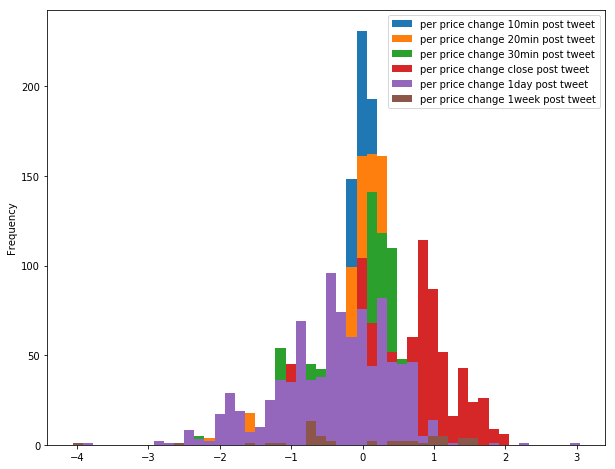

In [20]:

timeframes = [
    'per price change 10min post tweet',
    'per price change 20min post tweet',
    'per price change 30min post tweet',
    'per price change close post tweet',
    'per price change 1day post tweet',
    'per price change 1week post tweet']

hist_10min = all_down[timeframes]
lines2 = hist_10min.plot.hist(bins=50, figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110410f28>,
      dtype=object)

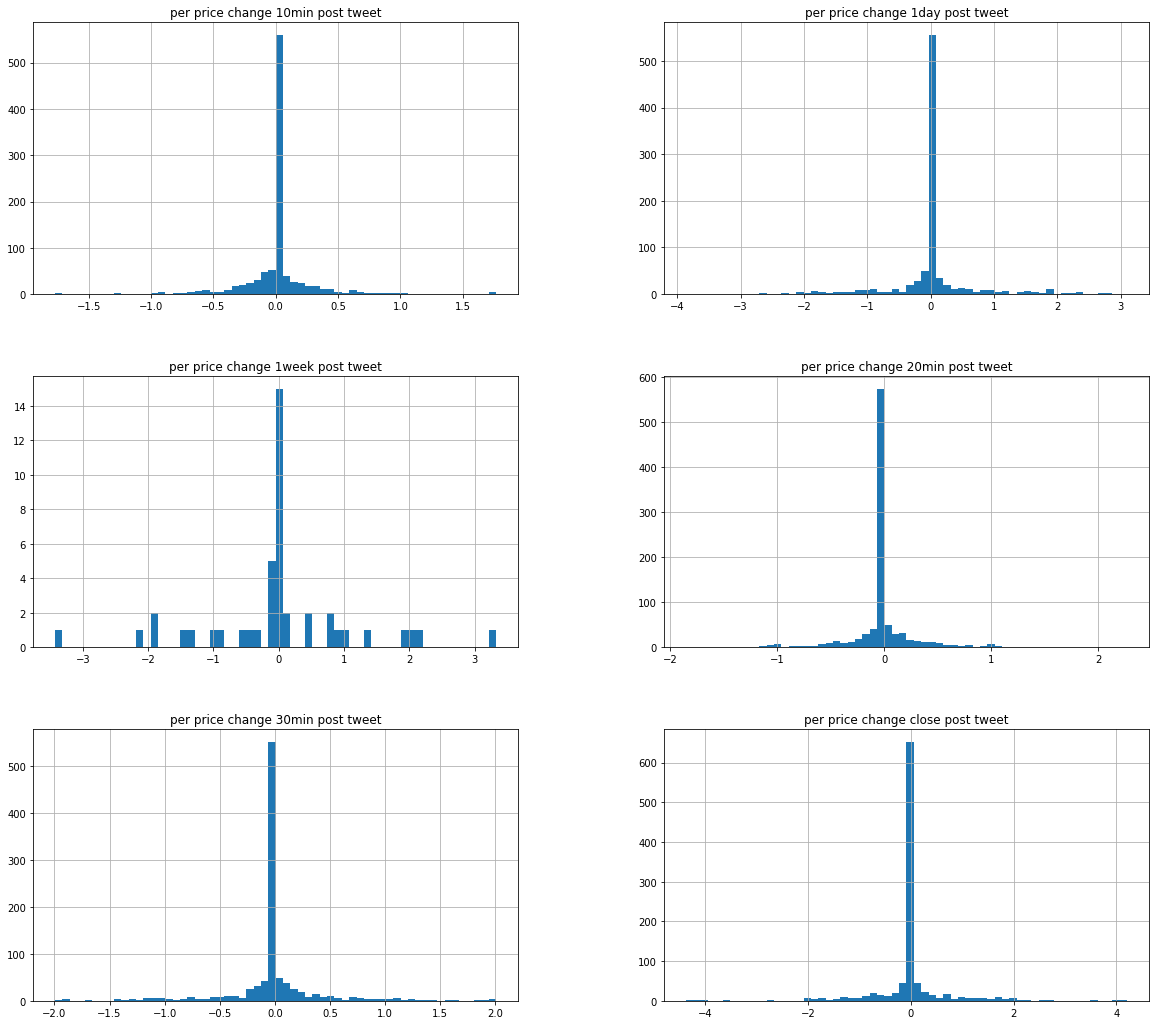

In [21]:
#plt.figure();

hist_10min.diff().hist(bins=60, figsize=(20, 18))



In [22]:
"""
Nominal Results of buying $1,000 dollars worth of a stock in the following scenarios

Upward Trending 
- Buy at Tweet Time -> End of Day
- Buy at Tweet Time -> 1 Week
- Buy 10min Post Tweet Time -> End of Day
- Buy 10min Post Tweet Time -> 1 Week

Downward Trending
- Buy at Tweet Time -> End of Day
- Buy at Tweet Time -> 1 Week
- Buy 10min Post Tweet Time -> End of Day
- Buy 10min Post Tweet Time -> 1 Week

"""
profit_T_EOD = []
profit_T_nextday =[]
profit_T_1week = []
profit_10_EOD = []
profit_10_nextday =[]
profit_10_1week = []
profit_20_EOD = []
profit_20_nextday =[]
profit_30_EOD = []
profit_30_nextday =[]
trade_allotment = 1000

for row in df_market_hours.index:
    trade_profit_T_EOD = ''
    trade_profit_T_nextday = ''
    trade_profit_T_1week = ''
    trade_profit_10_EOD = ''
    trade_profit_10_nextday = ''
    trade_profit_10_1week =''
    trade_profit_20_EOD = ''
    trade_profit_20_nextday = ''
    trade_profit_30_EOD = ''
    trade_profit_30_nextday = ''
    try:
        trade_profit_T_EOD = (trade_allotment * (df_market_hours['per price change close post tweet'][row]/100))
        trade_profit_T_nextday = (trade_allotment * (df_market_hours['per price change 1day post tweet'][row]/100))
        trade_profit_T_1week = (trade_allotment * (df_market_hours['per price change 1week post tweet'][row]/100))
        trade_profit_10_EOD =   trade_allotment * (df_market_hours['tweet day stock close price'][row] - df_market_hours['price 10min post tweet'][row])/ df_market_hours['price 10min post tweet'][row]
        trade_profit_10_nextday = trade_allotment * (df_market_hours['price 1day post tweet'][row] - df_market_hours['price 10min post tweet'][row])/ df_market_hours['price 10min post tweet'][row]
        trade_profit_10_1week = trade_allotment * (df_market_hours['price 1week post tweet'][row] - df_market_hours['price 10min post tweet'][row])/ df_market_hours['price 10min post tweet'][row]
        trade_profit_20_EOD =   trade_allotment * (df_market_hours['tweet day stock close price'][row] - df_market_hours['price 20min post tweet'][row])/ df_market_hours['price 20min post tweet'][row]
        trade_profit_20_nextday = trade_allotment * (df_market_hours['price 1day post tweet'][row] - df_market_hours['price 20min post tweet'][row])/ df_market_hours['price 20min post tweet'][row]
        trade_profit_30_EOD =   trade_allotment * (df_market_hours['tweet day stock close price'][row] - df_market_hours['price 30min post tweet'][row])/ df_market_hours['price 30min post tweet'][row]
        trade_profit_30_nextday = trade_allotment * (df_market_hours['price 1day post tweet'][row] - df_market_hours['price 30min post tweet'][row])/ df_market_hours['price 10min post tweet'][row]

        
    except:
        pass
    profit_T_EOD.append(trade_profit_T_EOD)
    profit_T_nextday.append(trade_profit_T_nextday)
    profit_T_1week.append(trade_profit_T_1week)
    profit_10_EOD.append(trade_profit_10_EOD)
    profit_10_nextday.append(trade_profit_10_nextday)
    profit_10_1week.append(trade_profit_10_1week)
    profit_20_EOD.append(trade_profit_20_EOD)
    profit_20_nextday.append(trade_profit_20_nextday)
    profit_30_EOD.append(trade_profit_30_EOD)
    profit_30_nextday.append(trade_profit_30_nextday)
    

df_market_hours['profit_T_EOD'] = profit_T_EOD
df_market_hours['profit_T_nextday'] = profit_T_nextday
df_market_hours['profit_T_1week'] = profit_T_1week
df_market_hours['profit_10_EOD'] = profit_10_EOD
df_market_hours['profit_10_nextday'] = profit_10_nextday
df_market_hours['profit_10_1week'] = profit_10_1week
df_market_hours['profit_20_EOD'] = profit_20_EOD
df_market_hours['profit_20_nextday'] = profit_20_nextday
df_market_hours['profit_30_EOD'] = profit_30_EOD
df_market_hours['profit_30_nextday'] = profit_30_nextday


/Users/michaelsnow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


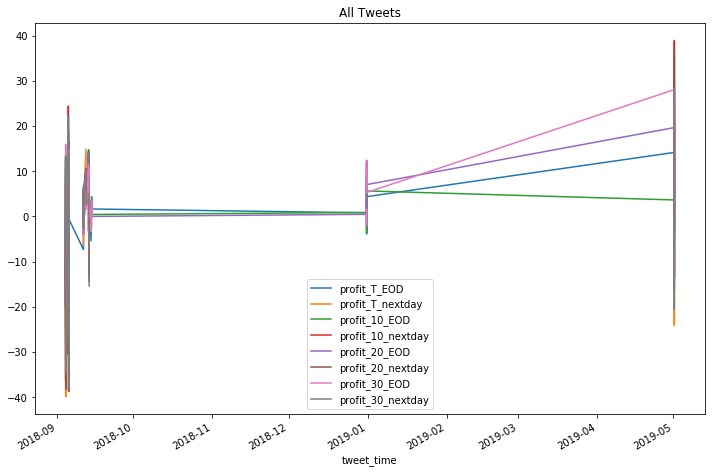

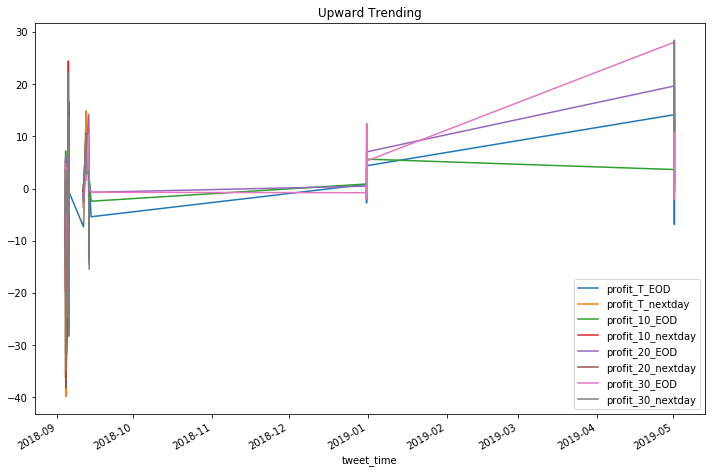

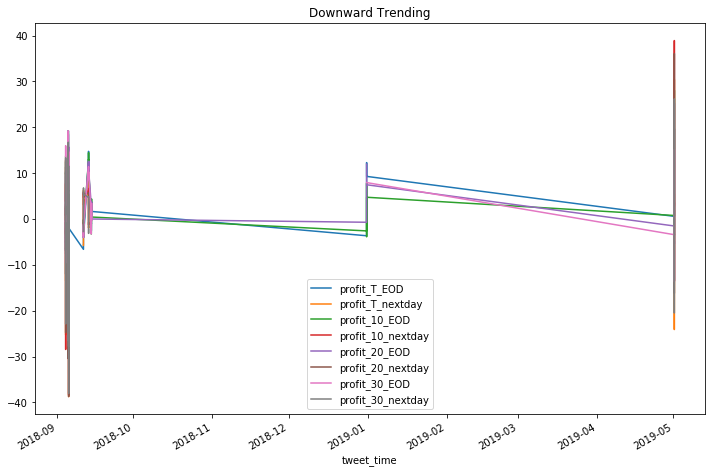

In [49]:
import matplotlib.dates as mdates
import matplotlib.dates as dates

scenarios = [
    'tweet_time',
    'profit_T_EOD',
    'profit_T_nextday',
    'profit_10_EOD',
    'profit_10_nextday',
    'profit_20_EOD',
    'profit_20_nextday',
    'profit_30_EOD',
    'profit_30_nextday'
]

line_data = df_market_hours[scenarios]
line_data_up = df_market_hours[scenarios].loc[subset_up]
line_data_down = df_market_hours[scenarios].loc[subset_down]

line_data['tweet_time'] = pd.to_datetime(line_data['tweet_time'])
line_data_up['tweet_time'] = pd.to_datetime(line_data_up['tweet_time'])
line_data_down['tweet_time'] = pd.to_datetime(line_data_down['tweet_time'])

line_data = line_data.set_index('tweet_time')
line_data_up = line_data_up.set_index('tweet_time')
line_data_down = line_data_down.set_index('tweet_time')

#line_data = line_data.cumsum()
#line_data_down =line_data_down.cumsum()
#line_data_up = line_data_up.cumsum()


line_plt1 = line_data.plot(figsize=(12,8), title="All Tweets")
line_plt2 = line_data_up.plot(figsize=(12,8), title="Upward Trending")
line_plt3= line_data_down.plot(figsize=(12,8), title="Downward Trending")

#line_plt1.xaxis.set_minor_locator(dates.MonthLocator())



In [46]:


line_data.resample('D', how='count')


/Users/michaelsnow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  This is separate from the ipykernel package so we can avoid doing imports until


,profit_T_EOD,profit_T_nextday,profit_10_EOD,profit_10_nextday,profit_20_EOD,profit_20_nextday,profit_30_EOD,profit_30_nextday
tweet_time,,,,,,,,
2018-09-04,59,56,56,56,56,56,56,56
2018-09-05,1180,1139,1174,1139,1163,1139,1154,1139
2018-09-06,0,0,0,0,0,0,0,0
2018-09-07,0,0,0,0,0,0,0,0
2018-09-08,0,0,0,0,0,0,0,0
2018-09-09,0,0,0,0,0,0,0,0
2018-09-10,0,0,0,0,0,0,0,0
2018-09-11,37,37,37,37,37,37,37,37
2018-09-12,3,3,3,3,3,3,3,3
